## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Apply region mask to ocver the lane region to focus on.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## camera calibration using chessboard images

Perform camera calibration. 

* Use real world points as coordinates of corners and compute image coordinates using opencv functions
* With this information compute distortion coefficients and camera matrix.
* Original and undistorted images are shown below. Observe that, the curved lines in original image are due to distortion and are corrected in image on right.



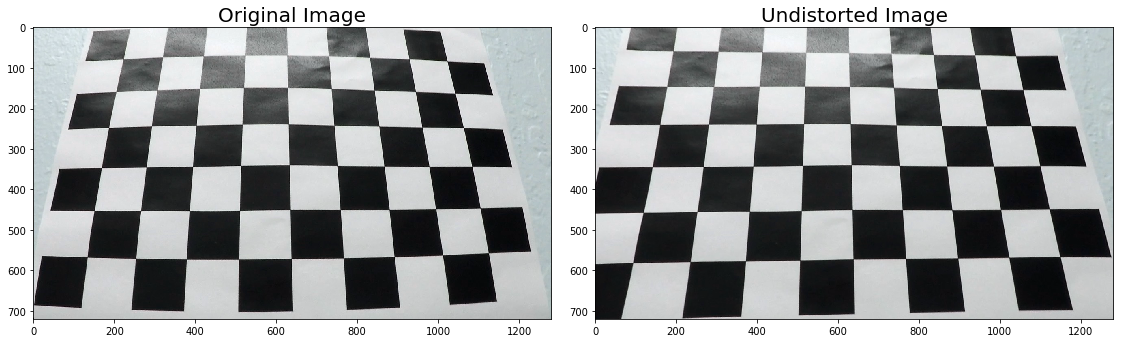

In [1]:
%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    #print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
 
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    #print (corners)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[1::-1], None, None)
image_raw = cv2.imread('../camera_cal/calibration3.jpg')
image = cv2.undistort(image_raw, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 15))
f.tight_layout()
ax1.imshow(image_raw)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Sample distortion corrected image

* we pick a sample test image and undistort it using camera matrix and distortion coefficients computed in camera calibration section.

* undistorted image is denoted as **image_undistort**.

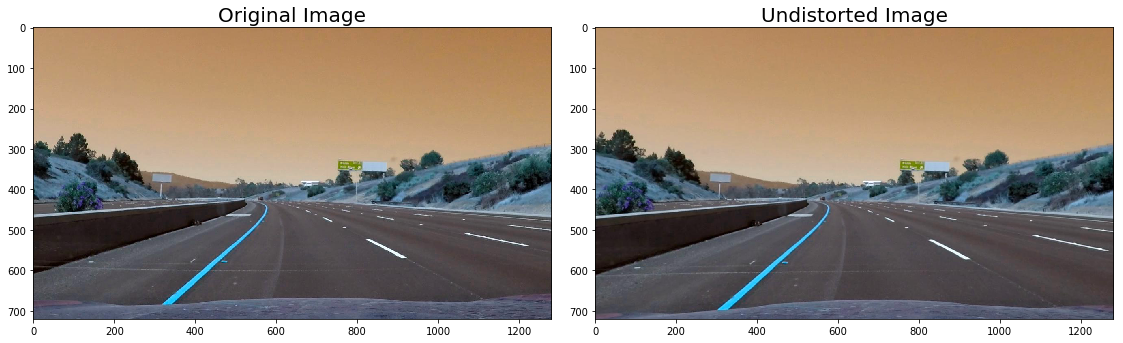

In [2]:
# Undistort a test image using above computed distortion coefficients and camera martix.

#Test image
image_raw = cv2.imread('../test_images/test_imagesframe0.jpg')

#openCV function to undistort camera image.
image_undistort = cv2.undistort(image_raw, mtx, dist, None, mtx)

#Plotting original and undistorted images.
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 15))
f.tight_layout()
ax1.imshow(image_raw)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(image_undistort)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Masking of undistorted image

* In this part of code, I defined a portion of the mimage that could most likely contain all the lane information needed. 

* This masked output is saved as **image** in below code. Further processing of lane detection is performed on this processed image.

Text(0.5,1,'Masked Image')

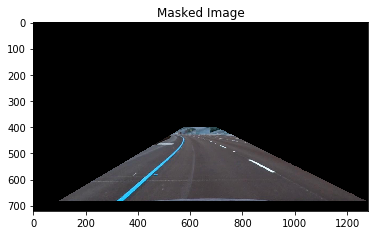

In [3]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



vertices = np.array([[(100,680),(575, 400), (700, 400), (1270,680)]], dtype=np.int32)
image = region_of_interest(image_undistort, vertices)
plt.imshow(image, cmap='gray') 
plt.title("Masked Image")
#print(combined.shape[0])



## Applying colour and gradient threasholds to obtain lane images

* Fundamental goal here is to identify white and yellow lane lines. After careful reading for HLS and LAB colour spaces, I am of the opinion that LAB coulour space is sufficient for this purpose. 
    * We can use Hue for detecting Yellow colour alone. Yellow is a combination of Red(Hue = 0 degree) and Green( Hue = 120 degree). Therefore an angular dimension of 30 degree to 90 degree seems to be a good threshold to start with.Based on conversion rules, for 8 bit images we can represent on 0 to 179 degrees. Hence the thresholds for H in this case to detect yellow are (15, 45) and they correspond to 30 degrees to 90 degrees. However, using B component in LAB coulur spaces yeilds better results. This component is desinged to capture blue and yellow components in an image. 
    * White lines are captured using lightness value component. Note that both components are availble in LAB coulour space and hence we will use that colour space for all our lane detection. 

* It is clear in the below output that B and L components of the image in LAB colour space captures yellow and white lanes in the image.

* **Since I used cv2.imread to read images, they are stored in BGR colour space format.**
    

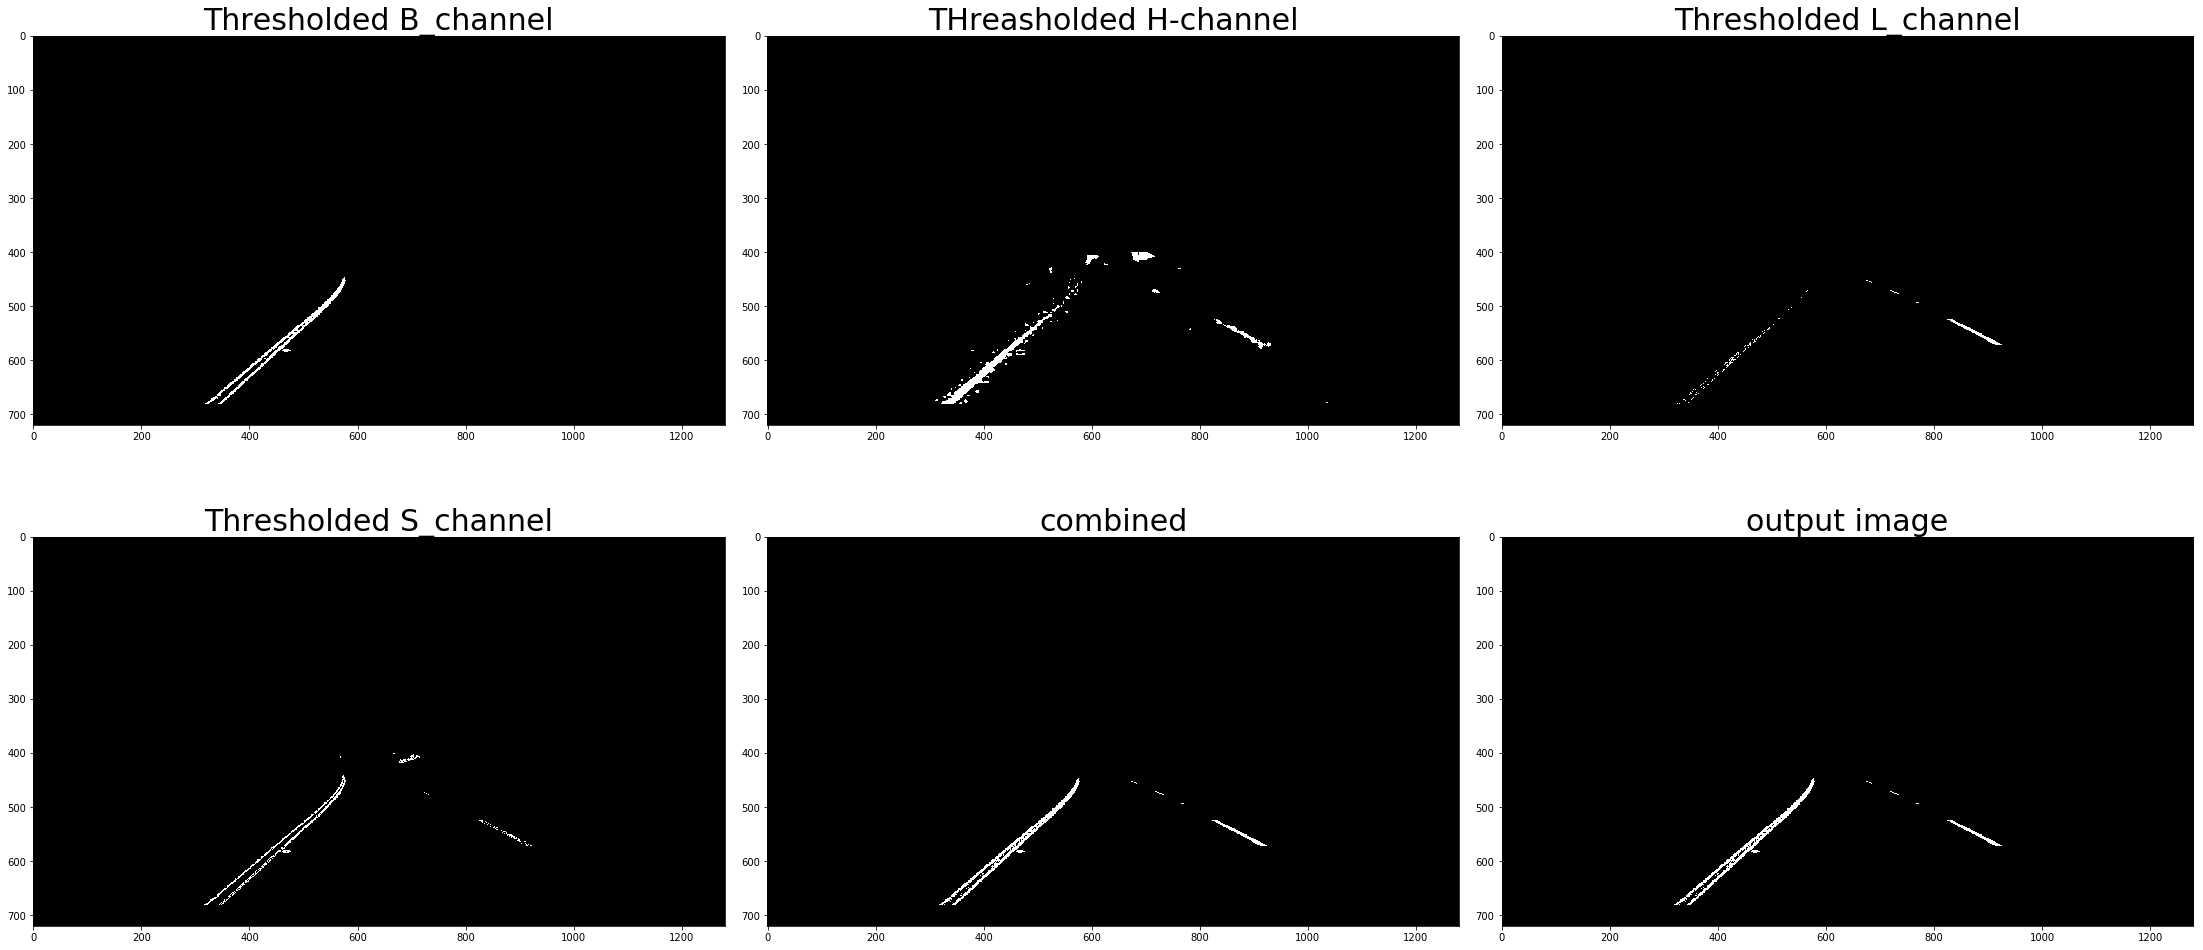

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(100, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(100, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    #binary_output = np.copy(img) # Remove this line
    return mag_binary


#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(10, 150))
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 250))


hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
s_channel = hls[:,:,2]
# Threshold color channel
s_thresh_min = 90
s_thresh_max = 200
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

h_channel = hls[:,:,0]
thresh = (20, 45)
h_binary = np.zeros_like(h_channel)
h_binary[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1

lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

b_channel = lab[:,:,2]
thresh = (155,200)
b_binary = np.zeros_like(b_channel)
b_binary[(b_channel > thresh[0]) & (b_channel <= thresh[1])] = 1

l_channel = lab[:,:,0]
thresh = (215,255)
l_binary = np.zeros_like(l_channel)
l_binary[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1


#Among all 
combined = np.zeros_like(s_binary)

#Only use L and B channel to detect lanes.
combined[((l_binary == 1) | (b_binary == 1))] = 1 


#Additional masking to remove the edges introduced due to initial masking. 
vertices = np.array([[(120,700),(575, 405), (700, 405), (1220,700)]], dtype=np.int32)
image_new = region_of_interest(combined, vertices)


f,((ax2,ax3,ax4),(ax5,ax6,ax7)) = plt.subplots(2,3, figsize=(30, 15))
f.tight_layout()
#ax1.imshow(image)
#ax1.set_title('Original Image', fontsize=50)
ax2.imshow(b_binary, cmap='gray')
ax2.set_title('Thresholded B_channel', fontsize=30)
ax3.imshow(h_binary, cmap='gray')
ax3.set_title('THreasholded H-channel', fontsize=30)
ax4.imshow(l_binary, cmap='gray')
ax4.set_title('Thresholded L_channel', fontsize=30)
ax5.imshow(s_binary, cmap='gray')
ax5.set_title('Thresholded S_channel', fontsize=30)
ax6.imshow(combined, cmap='gray')
ax6.set_title('combined', fontsize=30)
ax7.imshow(image_new, cmap='gray')
ax7.set_title('output image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Masking the region of lane lines

## Applying perspective transformation to compute radius of curvature

* In this section, I performed a careful search for source and destination point to get a good warped image for straight lanes and used it for all images.

Text(0.5,1,'Warped image')

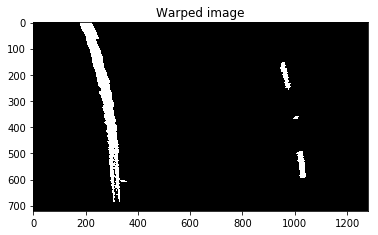

In [5]:


src = np.float32(
        [[580,460],
         [710,460],
         [200,720],
         [1150,720]])
dst = np.float32(
        [[250,0],
         [1000,0],
         [250,700],
         [1000,700]])


# M denotes the transform matrix
M = cv2.getPerspectiveTransform(src, dst)

#Minv denotes inverse transform matirx to convert back to real world corrdinates later
Minv = cv2.getPerspectiveTransform(dst, src)
img_size = (image_new.shape[1], image_new.shape[0])
warped = cv2.warpPerspective(image_new, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap='gray') 
plt.title("Warped image")

## Detecting lane pixels and fitting a polynomial for lane markings

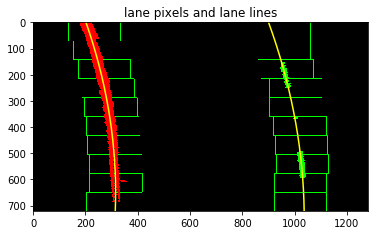

In [6]:
def polyfit(warped, image_new, plot_lanes):
    binary_warped = np.copy(warped)
    #print(binary_warped.shape[0]/2)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    #print(right_lane_inds.shape[0])
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    #print(leftx.shape)
    #print(rightx.shape)
    if (leftx.shape[0] == 0) or (rightx.shape[0] == 0):
        plt.imshow(image_new, cmap='gray')
        plt.title("Warped image")
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    if plot_lanes == True:
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        #out_img = np.dstack((warped, warped, warped))*255
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 255, 0]
        plt.imshow(out_img)
        plt.title("lane pixels and lane lines")
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)      
    
    return left_fit, right_fit

left_fit, right_fit = polyfit(warped,image_new,True)

## Computing Radius of curvatue and deviation from center of lane in real world

* Using the polynomial fit computed in above secition, radius of curvature of both lanes is computed for real world usage.

* Further, assuming that the camera is mounted on the center of the lane in a striaght lane, I computed the position with respect to center of lane by substracting the mid point of left fit  and right fit lanes and the center of image.

658.832154401 m 727.770846316 m
0.174318758939


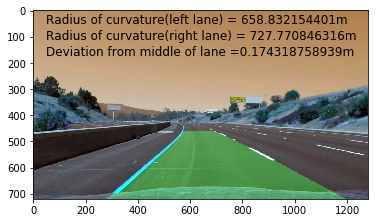

In [7]:

def Curvature_position_computation(image, warped,left_fit, right_fit, Minv):
    '''
    In this function we compute radius of curvature and position of vehicle with respect to center of lane.
    Assuming that camera is mounted in the center and if the vehicle is in center of the lane, 
    it would be exaclty in the middle of picture.
    '''
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define y-value where we want radius of curvature
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = image.shape[0]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/750 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    #print(pts_left)
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    #print(pts_right)
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_raw.shape[1], image_raw.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    
    pix_center_offset = abs(warped.shape[1]/2 - (left_fitx[-1]+right_fitx[-1])/2)*3.7/750
    print(pix_center_offset)
    
    plt.text(50, 50, "Radius of curvature(left lane) = " + str(left_curverad)+'m', fontsize=12)
    plt.text(50, 110, "Radius of curvature(right lane) = " + str(right_curverad)+'m', fontsize=12)
    plt.text(50, 170, "Deviation from middle of lane =" + str(pix_center_offset)+'m', fontsize=12)
    plt.imshow(result)
    
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad, pix_center_offset, result

left_curverad, right_curverad, offset, result = Curvature_position_computation(image_undistort, warped, left_fit, right_fit, Minv)

## Pipeling of lane detection for all test images 

In [8]:
import os
#os.listdir("test_images/")
#image_raw = cv2.imread('../test_images/test5.jpg')
def Combined_image(image):
    
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(10, 150))
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 250))

    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_thresh_min = 90
    s_thresh_max = 200
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    h_channel = hls[:,:,0]
    thresh = (20, 45)
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1

    l_channel = hls[:,:,1]
    thresh = (215,255)
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1


    lab= cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    b_channel = lab[:,:,2]
    thresh = (155,255)
    b_binary = np.zeros_like(l_channel)
    b_binary[(b_channel > thresh[0]) & (b_channel <= thresh[1])] = 1

    #Among all
    combined= np.zeros_like(s_binary)
    #combined[((gradx == 1) & (mag_binary == 1)) | ((s_binary == 1) & (h_binary == 1)) | ((l_binary == 1) | (b_binary == 1))] = 1 
    combined[((l_binary == 1)) | ((b_binary == 1))] = 1 
    #combined[((mag_binary == 1)) | ((s_binary == 1) & (binary == 1))] = 1 
    vertices = np.array([[(120,image_raw.shape[0]-10),(575, 405), (700, 405), (1220,image_raw.shape[0]-10)]], dtype=np.int32)
    image_new = region_of_interest(combined, vertices)
    
    return image_new


def lane_processing(image_raw, mtx, dist, M, Minv):
    image = cv2.undistort(image_raw, mtx, dist, None, mtx)
    

    #vertices = np.array([[(50,image_raw.shape[0]),(575, 450), (750, 450), (1200,image_raw.shape[0])]], dtype=np.int32)
    vertices = np.array([[(100,image_raw.shape[0]),(575, 400), (700, 400), (1270,image_raw.shape[0])]], dtype=np.int32)
    masked_region_image = region_of_interest(image, vertices)
    
    combined = Combined_image(masked_region_image)
    
    img_size = (combined.shape[1], combined.shape[0])
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

    left_fit, right_fit = polyfit(warped,combined, False)

    left_curverad, right_curverad, offset, result = Curvature_position_computation(image_raw, warped, left_fit, right_fit, Minv)
    
    cv2.putText(result, 'radius of curvature of left lane {:.2f}m '.format(left_curverad), (100,80),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    cv2.putText(result, 'radius of curvature of right lane {:.2f}m '.format(right_curverad), (100,140),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Offset {:.2f}(m)'.format(offset), (120,190),
             fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    
    return result




##  Lane detection for all test images 

../test_images/test_imagesframe1.2.jpg


TypeError: expected non-empty vector for x

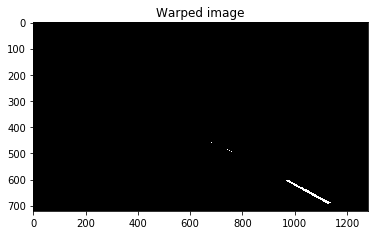

In [9]:
images = os.listdir("../test_images/")

for img in images:
    if ('.ipynb' not in img):
        print ('../test_images/' +  img)
        image = cv2.imread('../test_images/' +  img)
        #gray = cv2.COLOR_RGB2GRAY(image)
        #image = mpimg.imread('test_images/solidYellowCurve2.jpg')
        lane_detect_image = lane_processing(image, mtx, dist, M, Minv)
        #plt.imshow(lane_detect_image)
        mpimg.imsave('../output_images/' + 'processed_' + img, lane_detect_image)
    

## Pipeling of lane detection for test video 

In [10]:
def lane_video(image_raw):
    
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[1::-1], None, None)
    #mpimg.imsave('../test_images/' + 'raw1' + '.jpg', image_raw)
    image = cv2.undistort(image_raw, mtx, dist, None, mtx)
    
    #mpimg.imsave('../test_images/' + 'undistorted_1' + '.jpg', image)
    #vertices = np.array([[(50,image_raw.shape[0]),(575, 450), (750, 450), (1200,image_raw.shape[0])]], dtype=np.int32)
    vertices = np.array([[(100,image_raw.shape[0]),(575, 400), (700, 400), (1270,image_raw.shape[0])]], dtype=np.int32)
    masked_region_image = region_of_interest(image, vertices)
    
    combined = Combined_image(masked_region_image)
    
    img_size = (combined.shape[1], combined.shape[0])
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

    left_fit, right_fit = polyfit(warped,combined, False)

    left_curverad, right_curverad, offset, result = Curvature_position_computation(image_raw, warped, left_fit, right_fit, Minv)
    
    cv2.putText(result, 'radius of curvature of left lane{:.2f}m '.format(left_curverad), (100,80),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    cv2.putText(result, 'radius of curvature of right lane{:.2f}m '.format(right_curverad), (100,140),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Offset {:.2f}(m)'.format(offset), (120,190),
             fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    
    return result
    



In [11]:
import imageio
imageio.plugins.ffmpeg.download()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.02154496/28549024 bytes (7.5%5193728/28549024 bytes (18.28183808/28549024 bytes (28.711321344/28549024 bytes (39.7%14532608/28549024 bytes (50.9%17539072/28549024 bytes (61.4%20512768/28549024 bytes (71.9%23396352/28549024 bytes (82.0%26402816/28549024 bytes (92.5%28549024/28549024 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/ffmpeg.linux64.


## Frame extraction from image based on time 

In [ ]:

def extract_frames(movie, times):
    clip = VideoFileClip(movie)
    for t in times:
        frame_name = "../test_images" + 'frame' + str(t) + '.jpg'
        clip.save_frame(frame_name, t)

movie = "../project_video.mp4"
imgdir = 'frames'
times = [0]

extract_frames(movie, times)

## Lane detection on Video

677.45370678 m 716.880066672 m
0.175176769972
[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

677.45370678 m 716.880066672 m


  0%|          | 1/1261 [00:00<05:19,  3.94it/s]

0.175176769972


  0%|          | 2/1261 [00:00<05:40,  3.69it/s]

640.687058486 m 863.134627093 m
0.185166194177


  0%|          | 3/1261 [00:00<05:42,  3.67it/s]

611.267289514 m 1017.67572505 m
0.189620657054


  0%|          | 4/1261 [00:01<05:36,  3.74it/s]

594.825029525 m 695.448520902 m
0.185191038103


  0%|          | 5/1261 [00:01<05:39,  3.70it/s]

590.568281735 m 736.453396191 m
0.188342549445


  0%|          | 6/1261 [00:01<05:35,  3.74it/s]

596.435889748 m 751.054803477 m
0.194630967765


  1%|          | 7/1261 [00:01<05:32,  3.77it/s]

603.267982209 m 787.804772408 m
0.200617842083


  1%|          | 8/1261 [00:02<05:31,  3.78it/s]

611.673199363 m 1114.25007932 m
0.241411411271


  1%|          | 9/1261 [00:02<05:37,  3.71it/s]

609.002024494 m 1137.5202614 m
0.234369854092


  1%|          | 10/1261 [00:02<05:37,  3.70it/s]

637.829660941 m 1009.97896681 m
0.228972509514


  1%|          | 11/1261 [00:02<05:44,  3.63it/s]

661.158184974 m 1130.39421235 m
0.233697081339


  1%|          | 12/1261 [00:03<05:45,  3.61it/s]

731.457800363 m 1456.87838829 m
0.239263679357


  1%|          | 13/1261 [00:03<05:47,  3.59it/s]

761.522685627 m 1440.90560192 m
0.237927317022


  1%|          | 14/1261 [00:03<05:46,  3.59it/s]

820.762316568 m 1676.15168699 m
0.240177073299


  1%|          | 15/1261 [00:04<05:48,  3.57it/s]

874.841593578 m 1118.03036878 m
0.228864356038


  1%|▏         | 16/1261 [00:04<05:45,  3.60it/s]

869.19385236 m 967.339651743 m
0.214340173914


  1%|▏         | 17/1261 [00:04<05:50,  3.55it/s]

875.478388588 m 952.040908212 m
0.205055127896


  1%|▏         | 18/1261 [00:04<05:46,  3.58it/s]

898.002370351 m 937.228731363 m
0.200312223514


  2%|▏         | 19/1261 [00:05<05:45,  3.60it/s]

974.899352894 m 1036.71543925 m
0.200576025401


  2%|▏         | 20/1261 [00:05<05:47,  3.57it/s]

1062.18334529 m 1029.67654856 m
0.197655982901


  2%|▏         | 21/1261 [00:05<05:48,  3.56it/s]

1161.59883031 m 1278.10762288 m
0.202432372194


  2%|▏         | 22/1261 [00:06<05:46,  3.58it/s]

1181.10927613 m 974.246628745 m
0.181310182543


  2%|▏         | 23/1261 [00:06<05:47,  3.56it/s]

1176.89562664 m 1055.17997757 m
0.17501470902


  2%|▏         | 24/1261 [00:06<05:48,  3.55it/s]

1059.31290362 m 1116.276302 m
0.172631071338


  2%|▏         | 25/1261 [00:06<05:44,  3.59it/s]

954.557777085 m 993.967362142 m
0.157886138494


  2%|▏         | 26/1261 [00:07<05:41,  3.61it/s]

1052.37264578 m 843.685109931 m
0.147008552382


  2%|▏         | 27/1261 [00:07<05:41,  3.62it/s]

938.31818556 m 845.605243162 m
0.142709460549


  2%|▏         | 28/1261 [00:07<05:40,  3.62it/s]

941.99035756 m 888.88856681 m
0.142376419157


  2%|▏         | 29/1261 [00:08<05:41,  3.60it/s]

847.600014114 m 706.836066685 m
0.133711869431


  2%|▏         | 30/1261 [00:08<05:45,  3.56it/s]

714.589892804 m 682.386788046 m
0.123962938701


  2%|▏         | 31/1261 [00:08<05:49,  3.52it/s]

663.622442428 m 757.795054857 m
0.128417129298


  3%|▎         | 32/1261 [00:08<05:50,  3.51it/s]

611.377018152 m 689.70322239 m
0.12485295068


  3%|▎         | 33/1261 [00:09<05:49,  3.51it/s]

614.413063209 m 752.178609884 m
0.13191082775


  3%|▎         | 34/1261 [00:09<05:52,  3.48it/s]

572.902439948 m 891.029506547 m
0.148277041624


  3%|▎         | 35/1261 [00:09<05:55,  3.45it/s]

544.80416722 m 902.973231875 m
0.150320606145


  3%|▎         | 36/1261 [00:10<05:52,  3.47it/s]

532.294900917 m 896.396821867 m
0.15444770139


  3%|▎         | 37/1261 [00:10<05:52,  3.47it/s]

514.860747783 m 844.671000094 m
0.144702796211


  3%|▎         | 38/1261 [00:10<05:52,  3.47it/s]

489.866941999 m 747.507863447 m
0.138549893966


  3%|▎         | 39/1261 [00:10<05:52,  3.47it/s]

460.914869027 m 777.538695097 m
0.136508901459


  3%|▎         | 40/1261 [00:11<05:48,  3.50it/s]

463.204585561 m 871.428905021 m
0.14098531756


  3%|▎         | 41/1261 [00:11<05:50,  3.48it/s]

479.270319153 m 690.108495232 m
0.139677238054


  3%|▎         | 42/1261 [00:11<05:49,  3.48it/s]

476.711260133 m 666.367288334 m
0.144087399873


  3%|▎         | 43/1261 [00:12<07:43,  2.63it/s]

482.176303405 m 678.695033371 m
0.149753577798


  3%|▎         | 44/1261 [00:12<07:42,  2.63it/s]

498.067669918 m 642.29933181 m
0.151822731224


  4%|▎         | 45/1261 [00:13<08:52,  2.28it/s]

513.171229349 m 646.551016117 m
0.160149712295


  4%|▎         | 46/1261 [00:13<08:30,  2.38it/s]

528.637139876 m 889.499736302 m
0.187200126439


  4%|▎         | 47/1261 [00:14<08:09,  2.48it/s]

552.725382623 m 799.443780327 m
0.175683128739


  4%|▍         | 48/1261 [00:14<08:00,  2.52it/s]

559.814968901 m 776.826886902 m
0.177223876733


  4%|▍         | 49/1261 [00:14<07:41,  2.63it/s]

615.557287195 m 808.93338629 m
0.183307110179


  4%|▍         | 50/1261 [00:15<07:46,  2.60it/s]

663.245698775 m 828.842292845 m
0.187587336167


  4%|▍         | 51/1261 [00:15<07:32,  2.67it/s]

723.453251041 m 664.928907155 m
0.176388796335


  4%|▍         | 52/1261 [00:15<07:38,  2.64it/s]

771.159771375 m 653.845696802 m
0.178598050389


  4%|▍         | 53/1261 [00:16<07:27,  2.70it/s]

835.936160429 m 744.098421239 m
0.181244847877


  4%|▍         | 54/1261 [00:16<07:38,  2.63it/s]

909.856144062 m 678.359763361 m
0.178343173041


  4%|▍         | 55/1261 [00:17<07:28,  2.69it/s]

964.20749858 m 650.712899426 m
0.176844753613


  4%|▍         | 56/1261 [00:17<07:39,  2.62it/s]

1097.88217414 m 696.149299596 m
0.177195674331


  5%|▍         | 57/1261 [00:17<07:34,  2.65it/s]

1098.30371765 m 674.059216335 m
0.176506875573


  5%|▍         | 58/1261 [00:18<07:42,  2.60it/s]

1138.8475735 m 723.233267918 m
0.173926308234


  5%|▍         | 59/1261 [00:18<07:30,  2.67it/s]

994.876810582 m 905.35924164 m
0.189001377392


  5%|▍         | 60/1261 [00:18<07:31,  2.66it/s]

883.570511151 m 912.127404626 m
0.170765573849


  5%|▍         | 61/1261 [00:19<07:15,  2.76it/s]

815.821754067 m 1063.75656537 m
0.161026666244


  5%|▍         | 62/1261 [00:19<07:19,  2.73it/s]

819.409334564 m 930.407406602 m
0.15000320249


  5%|▍         | 63/1261 [00:19<07:06,  2.81it/s]

828.399231285 m 879.513860811 m
0.13430812342


  5%|▌         | 64/1261 [00:20<07:13,  2.76it/s]

777.833429056 m 957.809289396 m
0.127247930779


  5%|▌         | 65/1261 [00:20<07:05,  2.81it/s]

730.456759355 m 965.116116846 m
0.115010920855


  5%|▌         | 66/1261 [00:21<07:20,  2.71it/s]

711.33986994 m 916.108220657 m
0.106699303831


  5%|▌         | 67/1261 [00:21<07:10,  2.77it/s]

770.514109386 m 926.086692563 m
0.0997294697979


  5%|▌         | 68/1261 [00:21<07:18,  2.72it/s]

745.082414241 m 951.19755187 m
0.0893404785615


  5%|▌         | 69/1261 [00:22<07:08,  2.78it/s]

738.045049608 m 921.223575201 m
0.0856696106184


  6%|▌         | 70/1261 [00:22<07:19,  2.71it/s]

720.876326424 m 996.657121821 m
0.0810088115157


  6%|▌         | 71/1261 [00:22<07:07,  2.79it/s]

745.917250923 m 1509.88064484 m
0.104873124886


  6%|▌         | 72/1261 [00:23<07:17,  2.72it/s]

826.83035548 m 1527.80296877 m
0.0992497349265


  6%|▌         | 73/1261 [00:23<07:06,  2.78it/s]

905.7180269 m 1570.90332186 m
0.0976788874319


  6%|▌         | 74/1261 [00:23<07:13,  2.74it/s]

976.812149342 m 1371.24207988 m
0.0869817676504


  6%|▌         | 75/1261 [00:24<07:01,  2.81it/s]

1203.47285832 m 1494.90185772 m
0.08517256489


  6%|▌         | 76/1261 [00:24<07:07,  2.77it/s]

1259.95786704 m 938.173307468 m
0.0680142254383


  6%|▌         | 77/1261 [00:25<06:58,  2.83it/s]

1428.16072784 m 922.085164281 m
0.064518420689


  6%|▌         | 78/1261 [00:25<07:04,  2.79it/s]

1865.28752576 m 933.435841708 m
0.0671964997104


  6%|▋         | 79/1261 [00:25<06:56,  2.84it/s]

1945.00783785 m 935.594082973 m
0.0594385778999


  6%|▋         | 80/1261 [00:26<07:01,  2.80it/s]

1986.11191468 m 640.488621259 m
0.0441452394295


  6%|▋         | 81/1261 [00:26<07:03,  2.79it/s]

1971.65417763 m 683.46371888 m
0.0373563566259


  7%|▋         | 82/1261 [00:26<06:52,  2.86it/s]

1836.09883154 m 721.046566461 m
0.029680397607


  7%|▋         | 83/1261 [00:27<06:56,  2.83it/s]

1590.3073435 m 742.42470195 m
0.0277047487911


  7%|▋         | 84/1261 [00:27<07:00,  2.80it/s]

1973.47443377 m 1371.11428903 m
0.0719913716109


  7%|▋         | 85/1261 [00:27<06:49,  2.87it/s]

1557.82053733 m 1052.36087308 m
0.0475454597216


  7%|▋         | 86/1261 [00:28<06:54,  2.83it/s]

1267.42912857 m 992.07487356 m
0.0330840360064


  7%|▋         | 87/1261 [00:28<06:58,  2.81it/s]

959.391661907 m 1085.66555408 m
0.0272126206499


  7%|▋         | 88/1261 [00:28<07:00,  2.79it/s]

825.367578791 m 734.519870348 m
0.00246752646152


  7%|▋         | 89/1261 [00:29<06:50,  2.85it/s]

774.357875195 m 997.538613655 m
0.00806768472399


  7%|▋         | 90/1261 [00:29<07:03,  2.76it/s]

717.823706092 m 736.967972494 m
0.00132963099341


  7%|▋         | 91/1261 [00:29<06:54,  2.82it/s]

689.362649683 m 796.164191597 m
0.000685413248251


  7%|▋         | 92/1261 [00:30<07:05,  2.75it/s]

711.906800136 m 837.576454756 m
0.00570577300957


  7%|▋         | 93/1261 [00:30<06:55,  2.81it/s]

688.680760021 m 848.17313006 m
0.00366211771392


  7%|▋         | 94/1261 [00:31<06:55,  2.81it/s]

703.420900042 m 821.626190742 m
0.00751236538233


  8%|▊         | 95/1261 [00:31<06:59,  2.78it/s]

697.323411862 m 899.589090438 m
0.00484331500648


  8%|▊         | 96/1261 [00:31<06:49,  2.85it/s]

679.211323008 m 1044.65051986 m
0.0171739600123


  8%|▊         | 97/1261 [00:32<06:53,  2.82it/s]

717.080074877 m 902.279541607 m
0.0098799584939


  8%|▊         | 98/1261 [00:32<06:56,  2.80it/s]

707.149721995 m 1004.67310042 m
0.0147594956464


  8%|▊         | 99/1261 [00:33<07:50,  2.47it/s]

712.463084829 m 1020.97526496 m
0.0180627344843


  8%|▊         | 100/1261 [00:33<07:58,  2.43it/s]

748.894413941 m 986.213659508 m
0.0179149077032


  8%|▊         | 101/1261 [00:33<07:44,  2.50it/s]

757.736926185 m 547.932835452 m
0.00976533313785


  8%|▊         | 102/1261 [00:34<07:19,  2.63it/s]

754.398791903 m 642.212393474 m
0.00309993424089


  8%|▊         | 103/1261 [00:34<07:19,  2.63it/s]

732.528318519 m 664.003233401 m
0.0098475983806


  8%|▊         | 104/1261 [00:35<07:59,  2.41it/s]

753.936021016 m 639.960591474 m
0.0171473736418


  8%|▊         | 105/1261 [00:35<07:33,  2.55it/s]

802.057248681 m 662.413043333 m
0.0271363965631


  8%|▊         | 106/1261 [00:35<07:28,  2.58it/s]

794.382576886 m 731.566539675 m
0.0341030032967


  8%|▊         | 107/1261 [00:36<07:08,  2.69it/s]

780.177076196 m 771.755978057 m
0.0416929032395


  9%|▊         | 108/1261 [00:36<07:08,  2.69it/s]

700.118056245 m 781.793180983 m
0.0497816994025


  9%|▊         | 109/1261 [00:36<06:53,  2.79it/s]

677.770981292 m 1010.70294163 m
0.0732378899303


  9%|▊         | 110/1261 [00:37<06:56,  2.77it/s]

690.519418756 m 924.642900999 m
0.0681626755192


  9%|▉         | 111/1261 [00:37<06:44,  2.85it/s]

666.433196304 m 1079.72018637 m
0.0792320338418


  9%|▉         | 112/1261 [00:37<06:49,  2.81it/s]

703.049464455 m 1276.52786818 m
0.0875953221029


  9%|▉         | 113/1261 [00:38<06:42,  2.85it/s]

666.543374489 m 1243.65855671 m
0.0893139031661


  9%|▉         | 114/1261 [00:38<06:50,  2.79it/s]

637.54245301 m 984.822523311 m
0.0796412537616


  9%|▉         | 115/1261 [00:38<06:42,  2.85it/s]

592.349045311 m 1138.63275498 m
0.0856809275447


  9%|▉         | 116/1261 [00:39<06:49,  2.80it/s]

599.572407289 m 567.864800528 m
0.0637002693898


  9%|▉         | 117/1261 [00:39<06:41,  2.85it/s]

600.661226467 m 642.165514198 m
0.0734074377233


  9%|▉         | 118/1261 [00:39<06:51,  2.78it/s]

586.494867263 m 559.972304225 m
0.0732252972552


  9%|▉         | 119/1261 [00:40<06:42,  2.84it/s]

584.640310096 m 550.26416472 m
0.0796256535562


 10%|▉         | 120/1261 [00:40<06:50,  2.78it/s]

549.854492233 m 541.353461885 m
0.0850740119057


 10%|▉         | 121/1261 [00:41<07:09,  2.66it/s]

542.934633854 m 554.921393328 m
0.0905879958951


 10%|▉         | 122/1261 [00:41<06:55,  2.74it/s]

538.852901758 m 568.098229566 m
0.103872140028


 10%|▉         | 123/1261 [00:41<06:57,  2.73it/s]

530.126337643 m 583.847953418 m
0.110308265316


 10%|▉         | 124/1261 [00:42<06:42,  2.82it/s]

538.260360656 m 591.8854037 m
0.117276715306


 10%|▉         | 125/1261 [00:42<06:49,  2.77it/s]

534.299954126 m 616.333124343 m
0.124883711902


 10%|▉         | 126/1261 [00:42<06:39,  2.84it/s]

576.924574796 m 562.003433437 m
0.121726453952


 10%|█         | 127/1261 [00:43<06:45,  2.79it/s]

577.695847553 m 555.7440109 m
0.129971090031


 10%|█         | 128/1261 [00:43<06:39,  2.84it/s]

608.438032416 m 587.192330325 m
0.138524100486


 10%|█         | 129/1261 [00:43<06:47,  2.78it/s]

594.553802196 m 654.350132013 m
0.147888638862


 10%|█         | 130/1261 [00:44<06:37,  2.85it/s]

611.198090076 m 591.408165346 m
0.142362510811


 10%|█         | 131/1261 [00:44<06:45,  2.79it/s]

626.402216917 m 583.800073876 m
0.148091391101


 10%|█         | 132/1261 [00:44<06:34,  2.86it/s]

606.739015932 m 626.650886789 m
0.153023773467


 11%|█         | 133/1261 [00:45<06:44,  2.79it/s]

642.9926837 m 658.399183487 m
0.162762004339


 11%|█         | 134/1261 [00:45<06:47,  2.77it/s]

668.629547515 m 778.12518338 m
0.192534398187


 11%|█         | 135/1261 [00:46<06:51,  2.73it/s]

674.607156584 m 728.625493455 m
0.186120289746


 11%|█         | 136/1261 [00:46<06:40,  2.81it/s]

719.840581001 m 853.509333089 m
0.199002872252


 11%|█         | 137/1261 [00:46<06:50,  2.74it/s]

747.043084685 m 798.796451029 m
0.192698358993


 11%|█         | 138/1261 [00:47<06:41,  2.80it/s]

770.685474671 m 851.086274381 m
0.193890601932


 11%|█         | 139/1261 [00:47<06:51,  2.73it/s]

798.084188147 m 671.398769449 m
0.177799217129


 11%|█         | 140/1261 [00:47<06:38,  2.82it/s]

854.70624783 m 881.729034796 m
0.187799201885


 11%|█         | 141/1261 [00:48<06:44,  2.77it/s]

852.619222837 m 945.502724397 m
0.187580510268


 11%|█▏        | 142/1261 [00:48<06:35,  2.83it/s]

854.283575228 m 944.508341136 m
0.182986206055


 11%|█▏        | 143/1261 [00:48<06:42,  2.77it/s]

779.209344561 m 831.650831004 m
0.173504098315


 11%|█▏        | 144/1261 [00:49<06:33,  2.84it/s]

783.022933689 m 951.727798389 m
0.167489989059


 11%|█▏        | 145/1261 [00:49<06:44,  2.76it/s]

820.390412151 m 947.422801666 m
0.168535560563


 12%|█▏        | 146/1261 [00:50<06:35,  2.82it/s]

827.222973179 m 915.948255903 m
0.170711112966


 12%|█▏        | 147/1261 [00:50<06:42,  2.77it/s]

847.570839836 m 1664.19694942 m
0.203851346559


 12%|█▏        | 148/1261 [00:50<06:32,  2.84it/s]

799.44467032 m 1273.90043015 m
0.191650726016


 12%|█▏        | 149/1261 [00:51<06:43,  2.75it/s]

833.004328546 m 1669.76778894 m
0.200440312083


 12%|█▏        | 150/1261 [00:51<06:37,  2.80it/s]

876.069962676 m 1440.7896896 m
0.190578757009


 12%|█▏        | 151/1261 [00:51<06:45,  2.74it/s]

941.928938911 m 1070.9127534 m
0.17437878129


 12%|█▏        | 152/1261 [00:52<06:35,  2.80it/s]

932.032358347 m 1178.09553396 m
0.168669703469


 12%|█▏        | 153/1261 [00:52<06:42,  2.75it/s]

920.221518594 m 737.285636497 m
0.150369207504


 12%|█▏        | 154/1261 [00:53<07:26,  2.48it/s]

982.70201924 m 734.918954295 m
0.151289871066


 12%|█▏        | 155/1261 [00:53<08:08,  2.26it/s]

978.977712532 m 774.869912837 m
0.150793516808


 12%|█▏        | 156/1261 [00:53<07:43,  2.38it/s]

886.952401723 m 719.12852787 m
0.141062604611


 12%|█▏        | 157/1261 [00:54<07:14,  2.54it/s]

904.326957227 m 713.399622199 m
0.138234351064


 13%|█▎        | 158/1261 [00:54<07:09,  2.57it/s]

745.841055345 m 681.097523898 m
0.122867081421


 13%|█▎        | 159/1261 [00:55<06:51,  2.68it/s]

778.108300117 m 941.782524859 m
0.150070696094


 13%|█▎        | 160/1261 [00:55<06:53,  2.66it/s]

718.678606735 m 974.406296604 m
0.14316462914


 13%|█▎        | 161/1261 [00:55<06:39,  2.75it/s]

716.363817377 m 1014.09017681 m
0.141621110576


 13%|█▎        | 162/1261 [00:56<06:46,  2.70it/s]

718.029968293 m 903.687750146 m
0.130585787847


 13%|█▎        | 163/1261 [00:56<06:34,  2.78it/s]

730.565778503 m 1000.23873532 m
0.133418653711


 13%|█▎        | 164/1261 [00:56<06:35,  2.77it/s]

708.183910165 m 1633.07108431 m
0.143478064704


 13%|█▎        | 165/1261 [00:57<06:57,  2.62it/s]

673.921042739 m 1407.18748369 m
0.131206526484


 13%|█▎        | 166/1261 [00:57<06:42,  2.72it/s]

732.102704791 m 1699.91624854 m
0.130562034616


 13%|█▎        | 167/1261 [00:57<06:47,  2.68it/s]

671.283079835 m 866.734096565 m
0.112036816639


 13%|█▎        | 168/1261 [00:58<06:37,  2.75it/s]

710.323735382 m 920.523592656 m
0.113619310838


 13%|█▎        | 169/1261 [00:58<06:43,  2.70it/s]

771.726203727 m 851.585190304 m
0.113134545697


 13%|█▎        | 170/1261 [00:59<06:29,  2.80it/s]

870.321895389 m 917.764992918 m
0.109877892173


 14%|█▎        | 171/1261 [00:59<06:33,  2.77it/s]

951.641872599 m 789.597498128 m
0.096447859889


 14%|█▎        | 172/1261 [00:59<06:22,  2.85it/s]

976.839251641 m 775.773983761 m
0.0876477277102


 14%|█▎        | 173/1261 [01:00<06:27,  2.81it/s]

948.825856246 m 665.183809861 m
0.0728618927238


 14%|█▍        | 174/1261 [01:00<06:16,  2.89it/s]

883.896735401 m 704.05931233 m
0.0732506048887


 14%|█▍        | 175/1261 [01:00<06:21,  2.84it/s]

855.906957357 m 691.038095978 m
0.0694706394923


 14%|█▍        | 176/1261 [01:01<06:16,  2.88it/s]

793.3699 m 475.399796459 m
0.0384309382929


 14%|█▍        | 177/1261 [01:01<06:25,  2.81it/s]

889.277068491 m 501.858632749 m
0.043918285079


 14%|█▍        | 178/1261 [01:01<06:17,  2.87it/s]

895.28652631 m 562.070547395 m
0.0551485725684


 14%|█▍        | 179/1261 [01:02<06:26,  2.80it/s]

859.743636212 m 531.178622347 m
0.0576298229809


 14%|█▍        | 180/1261 [01:02<06:18,  2.85it/s]

793.233030049 m 488.009791154 m
0.0549251472704


 14%|█▍        | 181/1261 [01:02<06:24,  2.81it/s]

685.863958021 m 421.509135886 m
0.0500895060015


 14%|█▍        | 182/1261 [01:03<06:27,  2.78it/s]

675.877386651 m 426.234823021 m
0.0500124571723


 15%|█▍        | 183/1261 [01:03<06:35,  2.73it/s]

613.783383192 m 414.054483289 m
0.0497524936785


 15%|█▍        | 184/1261 [01:04<06:40,  2.69it/s]

561.275443229 m 455.826172726 m
0.0650155173212


 15%|█▍        | 185/1261 [01:04<06:50,  2.62it/s]

512.375850419 m 476.128716828 m
0.0676130823043


 15%|█▍        | 186/1261 [01:04<06:39,  2.69it/s]

444.318101629 m 445.320153656 m
0.0610986864905


 15%|█▍        | 187/1261 [01:05<06:46,  2.64it/s]

445.789222767 m 512.547058882 m
0.0738684266244


 15%|█▍        | 188/1261 [01:05<06:36,  2.71it/s]

427.215062997 m 449.282310062 m
0.0684245312548


 15%|█▍        | 189/1261 [01:05<06:42,  2.67it/s]

439.461485705 m 422.561659739 m
0.0691828471225


 15%|█▌        | 190/1261 [01:06<06:31,  2.73it/s]

452.797877431 m 519.705486121 m
0.089825383387


 15%|█▌        | 191/1261 [01:06<06:38,  2.69it/s]

439.020407387 m 526.704548746 m
0.0937556501857


 15%|█▌        | 192/1261 [01:06<06:27,  2.76it/s]

473.782328877 m 441.439494421 m
0.0985680383905


 15%|█▌        | 193/1261 [01:07<06:38,  2.68it/s]

486.172214753 m 601.405148033 m
0.117079664682


 15%|█▌        | 194/1261 [01:07<06:45,  2.63it/s]

533.500923289 m 611.288538998 m
0.124558921009


 15%|█▌        | 195/1261 [01:08<06:43,  2.64it/s]

547.03406646 m 625.125269131 m
0.128020797384


 16%|█▌        | 196/1261 [01:08<06:33,  2.71it/s]

611.451357777 m 724.850485839 m
0.137542630128


 16%|█▌        | 197/1261 [01:08<06:41,  2.65it/s]

659.199406217 m 819.270300865 m
0.138288266397


 16%|█▌        | 198/1261 [01:09<06:30,  2.72it/s]

729.110827743 m 881.323435095 m
0.136143930094


 16%|█▌        | 199/1261 [01:09<06:37,  2.67it/s]

780.570613614 m 900.869525696 m
0.129778360246


 16%|█▌        | 200/1261 [01:09<06:26,  2.74it/s]

806.517030979 m 968.091311703 m
0.131388510735


 16%|█▌        | 201/1261 [01:10<06:33,  2.69it/s]

887.561649425 m 845.552376136 m
0.118951811098


 16%|█▌        | 202/1261 [01:10<06:22,  2.77it/s]

863.511545657 m 826.225092709 m
0.113507087995


 16%|█▌        | 203/1261 [01:11<06:27,  2.73it/s]

859.681564461 m 820.484491664 m
0.106090339382


 16%|█▌        | 204/1261 [01:11<06:16,  2.81it/s]

794.166104907 m 870.166142872 m
0.0990992648484


 16%|█▋        | 205/1261 [01:11<06:31,  2.70it/s]

721.989928669 m 698.158618187 m
0.0892889380636


 16%|█▋        | 206/1261 [01:12<06:23,  2.75it/s]

704.42436933 m 691.997914905 m
0.0896703713087


 16%|█▋        | 207/1261 [01:12<06:29,  2.70it/s]

636.695631599 m 603.396268547 m
0.0870155482942


 16%|█▋        | 208/1261 [01:13<07:04,  2.48it/s]

609.329147618 m 880.88858235 m
0.11588533156


 17%|█▋        | 209/1261 [01:13<08:26,  2.08it/s]

633.633321037 m 701.947794854 m
0.107278206495


 17%|█▋        | 210/1261 [01:14<07:48,  2.24it/s]

635.662284967 m 717.702284058 m
0.10588723734


 17%|█▋        | 211/1261 [01:14<07:28,  2.34it/s]

644.523883966 m 709.689047284 m
0.0989187928573


 17%|█▋        | 212/1261 [01:14<06:59,  2.50it/s]

622.77637681 m 793.761342779 m
0.102267961406


 17%|█▋        | 213/1261 [01:15<06:55,  2.52it/s]

605.615312381 m 579.033080345 m
0.0774579634306


 17%|█▋        | 214/1261 [01:15<06:34,  2.65it/s]

587.995409615 m 684.666002503 m
0.0854115473426


 17%|█▋        | 215/1261 [01:15<06:39,  2.62it/s]

595.25317073 m 640.060464562 m
0.0756321352274


 17%|█▋        | 216/1261 [01:16<06:24,  2.72it/s]

580.942136507 m 625.966040452 m
0.0686624203104


 17%|█▋        | 217/1261 [01:16<06:27,  2.69it/s]

574.769767399 m 768.445378872 m
0.0671072625633


 17%|█▋        | 218/1261 [01:16<06:25,  2.71it/s]

615.78377949 m 818.078525081 m
0.0647978805723


 17%|█▋        | 219/1261 [01:17<06:34,  2.64it/s]

587.412122314 m 770.450448589 m
0.0608629459774


 17%|█▋        | 220/1261 [01:17<06:25,  2.70it/s]

636.019406285 m 849.138108647 m
0.0635207352681


 18%|█▊        | 221/1261 [01:18<06:30,  2.66it/s]

679.524999626 m 1400.04934625 m
0.100110265236


 18%|█▊        | 222/1261 [01:18<06:21,  2.72it/s]

707.959902175 m 1296.14174165 m
0.0937267859304


 18%|█▊        | 223/1261 [01:18<06:29,  2.67it/s]

751.406012124 m 1342.01915574 m
0.0917681775333


 18%|█▊        | 224/1261 [01:19<06:17,  2.74it/s]

751.375267583 m 1401.57637064 m
0.0874548071504


 18%|█▊        | 225/1261 [01:19<06:27,  2.67it/s]

769.292603535 m 2126.69368644 m
0.0888960087569


 18%|█▊        | 226/1261 [01:19<06:21,  2.71it/s]

762.369766242 m 2426.09114474 m
0.0778142780738


 18%|█▊        | 227/1261 [01:20<06:27,  2.67it/s]

822.468616624 m 2058.57218151 m
0.0641207924953


 18%|█▊        | 228/1261 [01:20<06:16,  2.75it/s]

885.613100738 m 1074.49134805 m
0.0464762859151


 18%|█▊        | 229/1261 [01:21<06:21,  2.70it/s]

889.446047024 m 825.425224838 m
0.030643689816


 18%|█▊        | 230/1261 [01:21<06:15,  2.74it/s]

951.013330886 m 857.659770228 m
0.0222653552502


 18%|█▊        | 231/1261 [01:21<06:24,  2.68it/s]

961.067536212 m 802.302906793 m
0.0147623941207


 18%|█▊        | 232/1261 [01:22<06:14,  2.75it/s]

1023.90182208 m 843.929018331 m
0.00544945615317


 18%|█▊        | 233/1261 [01:22<06:25,  2.67it/s]

987.313561545 m 894.23885936 m
0.00605031344989


 19%|█▊        | 234/1261 [01:22<06:13,  2.75it/s]

999.091381514 m 872.695041018 m
0.00239695223025


 19%|█▊        | 235/1261 [01:23<06:19,  2.71it/s]

913.856523645 m 991.613529793 m
0.00598271380563


 19%|█▊        | 236/1261 [01:23<06:12,  2.75it/s]

860.993253167 m 846.556473331 m
0.0184331737096


 19%|█▉        | 237/1261 [01:23<06:16,  2.72it/s]

861.684704559 m 595.584072954 m
0.0465437264764


 19%|█▉        | 238/1261 [01:24<06:06,  2.79it/s]

829.438255156 m 730.944995099 m
0.0377595538765


 19%|█▉        | 239/1261 [01:24<06:15,  2.72it/s]

834.598187079 m 643.100727899 m
0.0491038223745


 19%|█▉        | 240/1261 [01:25<06:07,  2.78it/s]

834.1304924 m 774.891121434 m
0.0453430807172


 19%|█▉        | 241/1261 [01:25<06:14,  2.72it/s]

774.206379863 m 670.788652684 m
0.0579368672601


 19%|█▉        | 242/1261 [01:25<06:04,  2.79it/s]

781.866185235 m 542.792583263 m
0.0639705339452


 19%|█▉        | 243/1261 [01:26<06:11,  2.74it/s]

719.122352729 m 548.000473639 m
0.0665939088154


 19%|█▉        | 244/1261 [01:26<06:04,  2.79it/s]

731.086448202 m 569.704060792 m
0.0719223336795


 19%|█▉        | 245/1261 [01:26<06:10,  2.74it/s]

692.917622412 m 780.947597168 m
0.0450208963697


 20%|█▉        | 246/1261 [01:27<06:00,  2.82it/s]

657.612851321 m 674.857607836 m
0.0606065320421


 20%|█▉        | 247/1261 [01:27<06:08,  2.75it/s]

666.348247063 m 763.371656132 m
0.0607263232525


 20%|█▉        | 248/1261 [01:27<06:01,  2.80it/s]

666.484529126 m 719.322389806 m
0.0644266810738


 20%|█▉        | 249/1261 [01:28<06:06,  2.76it/s]

684.461462087 m 632.83709244 m
0.0780796992203


 20%|█▉        | 250/1261 [01:28<05:59,  2.81it/s]

665.612416498 m 684.412994449 m
0.0749857069525


 20%|█▉        | 251/1261 [01:29<06:06,  2.75it/s]

717.530945248 m 575.719837502 m
0.0867070924645


 20%|█▉        | 252/1261 [01:29<05:58,  2.82it/s]

736.953149115 m 637.274916451 m
0.0814855429824


 20%|██        | 253/1261 [01:29<06:12,  2.71it/s]

747.634550864 m 642.851982412 m
0.0846217648607


 20%|██        | 254/1261 [01:30<06:03,  2.77it/s]

759.043228803 m 662.996807149 m
0.0825996778796


 20%|██        | 255/1261 [01:30<06:06,  2.75it/s]

718.125558965 m 665.101052622 m
0.0818339591666


 20%|██        | 256/1261 [01:30<05:56,  2.82it/s]

728.294696899 m 684.149642466 m
0.0818486737461


 20%|██        | 257/1261 [01:31<06:02,  2.77it/s]

709.272182156 m 957.411468281 m
0.0470518095708


 20%|██        | 258/1261 [01:31<05:55,  2.82it/s]

745.45079436 m 938.082224358 m
0.0550594716053


 21%|██        | 259/1261 [01:31<06:02,  2.76it/s]

713.632661734 m 919.386357035 m
0.0597512068522


 21%|██        | 260/1261 [01:32<05:54,  2.82it/s]

777.595212473 m 927.726530156 m
0.0546243867162


 21%|██        | 261/1261 [01:32<06:03,  2.75it/s]

835.439731912 m 910.770067816 m
0.0564512780383


 21%|██        | 262/1261 [01:32<05:53,  2.83it/s]

858.978842077 m 658.040990015 m
0.0694283090851


 21%|██        | 263/1261 [01:33<06:02,  2.76it/s]

860.00955158 m 566.29248356 m
0.0764836298453


 21%|██        | 264/1261 [01:33<05:52,  2.83it/s]

936.127555453 m 588.31539668 m
0.0709220430017


 21%|██        | 265/1261 [01:34<06:00,  2.76it/s]

899.792411027 m 637.93716142 m
0.0694444580512


 21%|██        | 266/1261 [01:34<05:54,  2.81it/s]

901.45074831 m 655.80957148 m
0.0667364360501


 21%|██        | 267/1261 [01:34<06:02,  2.74it/s]

855.726759675 m 681.48374377 m
0.062808539132


 21%|██▏       | 268/1261 [01:35<05:52,  2.82it/s]

854.160366009 m 693.075086639 m
0.0632713849055


 21%|██▏       | 269/1261 [01:35<06:00,  2.75it/s]

838.120137618 m 712.264748937 m
0.0634552053014


 21%|██▏       | 270/1261 [01:35<05:52,  2.81it/s]

797.404737192 m 930.666813907 m
0.0408658327359


 21%|██▏       | 271/1261 [01:36<05:57,  2.77it/s]

862.255311067 m 907.436730611 m
0.0376309004854


 22%|██▏       | 272/1261 [01:36<05:50,  2.82it/s]

784.176604901 m 856.44835243 m
0.0363890899386


 22%|██▏       | 273/1261 [01:36<05:57,  2.77it/s]

808.948023083 m 877.640945553 m
0.0356710538914


 22%|██▏       | 274/1261 [01:37<05:48,  2.84it/s]

768.78502976 m 765.13599336 m
0.0372683879184


 22%|██▏       | 275/1261 [01:37<05:58,  2.75it/s]

807.730345749 m 706.048947399 m
0.0382449890519


 22%|██▏       | 276/1261 [01:37<05:49,  2.82it/s]

919.26106409 m 834.46795337 m
0.0228805692627


 22%|██▏       | 277/1261 [01:38<05:52,  2.80it/s]

868.664582484 m 824.568724326 m
0.0266162130354


 22%|██▏       | 278/1261 [01:38<05:44,  2.86it/s]

940.255467357 m 810.918349266 m
0.0229700692376


 22%|██▏       | 279/1261 [01:39<05:50,  2.80it/s]

912.299484939 m 782.073310759 m
0.0213281685965


 22%|██▏       | 280/1261 [01:39<05:40,  2.88it/s]

941.619750585 m 815.280832882 m
0.0203345814321


 22%|██▏       | 281/1261 [01:39<05:49,  2.80it/s]

994.70069321 m 930.532176703 m
0.00184453908794


 22%|██▏       | 282/1261 [01:40<05:42,  2.86it/s]

934.573997917 m 997.528218727 m
0.00241968572908


 22%|██▏       | 283/1261 [01:40<06:00,  2.72it/s]

1028.21942684 m 1075.52832126 m
0.012774348493


 23%|██▎       | 284/1261 [01:40<05:50,  2.79it/s]

1110.94298001 m 1093.88102849 m
0.0221638090058


 23%|██▎       | 285/1261 [01:41<05:53,  2.76it/s]

1144.38685009 m 1174.52764589 m
0.0282266170325


 23%|██▎       | 286/1261 [01:41<05:44,  2.83it/s]

1199.32349881 m 1508.52383469 m
0.0387679831518


 23%|██▎       | 287/1261 [01:41<05:51,  2.77it/s]

1242.73241799 m 1369.30192834 m
0.0350906782582


 23%|██▎       | 288/1261 [01:42<05:41,  2.85it/s]

1237.23496851 m 1317.3437981 m
0.0383216415577


 23%|██▎       | 289/1261 [01:42<05:48,  2.79it/s]

1202.70607795 m 1039.79869716 m
0.0358167038932


 23%|██▎       | 290/1261 [01:42<05:40,  2.85it/s]

1264.63335384 m 995.47475652 m
0.0385221020562


 23%|██▎       | 291/1261 [01:43<05:47,  2.79it/s]

1249.24857223 m 1052.35734324 m
0.0430217562524


 23%|██▎       | 292/1261 [01:43<05:40,  2.84it/s]

1324.48500923 m 1040.94550699 m
0.0460874436064


 23%|██▎       | 293/1261 [01:44<06:17,  2.56it/s]

1391.04331358 m 1294.57318647 m
0.0638303462946


 23%|██▎       | 294/1261 [01:44<06:01,  2.67it/s]

1471.95084582 m 1262.2832213 m
0.0659679286834


 23%|██▎       | 295/1261 [01:44<05:44,  2.80it/s]

1375.05623985 m 1423.81321912 m
0.0695312372173


 23%|██▎       | 296/1261 [01:45<06:58,  2.31it/s]

1653.95548287 m 1299.69839758 m
0.0715404784316


 24%|██▎       | 297/1261 [01:45<07:42,  2.08it/s]

1565.48913066 m 1297.93870114 m
0.06440353999


 24%|██▎       | 298/1261 [01:46<07:16,  2.21it/s]

1519.90812948 m 1158.47426696 m
0.0624756539934


 24%|██▎       | 299/1261 [01:46<06:45,  2.37it/s]

1674.76211131 m 957.482118962 m
0.058013694949


 24%|██▍       | 300/1261 [01:47<06:35,  2.43it/s]

2355.59238991 m 997.697577075 m
0.0656680273004


 24%|██▍       | 301/1261 [01:47<06:16,  2.55it/s]

1649.64893596 m 1096.91619945 m
0.060813922868


 24%|██▍       | 302/1261 [01:47<06:19,  2.53it/s]

1987.70878638 m 1157.59970265 m
0.063907735587


 24%|██▍       | 303/1261 [01:48<06:06,  2.61it/s]

2231.23925767 m 1217.36571572 m
0.0658180912589


 24%|██▍       | 304/1261 [01:48<06:10,  2.59it/s]

2356.59793796 m 1184.45153206 m
0.0643280034415


 24%|██▍       | 305/1261 [01:48<05:58,  2.67it/s]

2193.02489074 m 3104.8179598 m
0.102801101397


 24%|██▍       | 306/1261 [01:49<06:00,  2.65it/s]

2267.97769194 m 2603.52756681 m
0.0953088965043


 24%|██▍       | 307/1261 [01:49<05:50,  2.72it/s]

2574.61739808 m 3540.985044 m
0.103059363093


 24%|██▍       | 308/1261 [01:50<05:55,  2.68it/s]

2289.87218622 m 2432.46355157 m
0.0968392762421


 25%|██▍       | 309/1261 [01:50<05:46,  2.75it/s]

2902.32427794 m 4133.7290286 m
0.102515361013


 25%|██▍       | 310/1261 [01:50<05:52,  2.69it/s]

2388.17117484 m 2407.14848663 m
0.0932734965141


 25%|██▍       | 311/1261 [01:51<05:45,  2.75it/s]

4549.94129504 m 49693.5361464 m
0.104570321776


 25%|██▍       | 312/1261 [01:51<05:59,  2.64it/s]

5969.34801592 m 7125.58612719 m
0.0982270306167


 25%|██▍       | 313/1261 [01:51<05:49,  2.72it/s]

4462.30920162 m 7086.23464258 m
0.0916958827197


 25%|██▍       | 314/1261 [01:52<05:56,  2.66it/s]

9851.05983567 m 6300.25989054 m
0.0929278645983


 25%|██▍       | 315/1261 [01:52<05:48,  2.72it/s]

6780.6652351 m 7053.45267287 m
0.0885552864101


 25%|██▌       | 316/1261 [01:53<05:54,  2.67it/s]

7929.92279826 m 6619.77030598 m
0.0875295476459


 25%|██▌       | 317/1261 [01:53<05:48,  2.71it/s]

11261.4657056 m 3759.80667076 m
0.11882932963


 25%|██▌       | 318/1261 [01:53<05:54,  2.66it/s]

21330.3372053 m 7043.27313123 m
0.10513156663


 25%|██▌       | 319/1261 [01:54<05:43,  2.75it/s]

33261.7480876 m 7004.15919715 m
0.101056458023


 25%|██▌       | 320/1261 [01:54<05:50,  2.68it/s]

50456.7762779 m 9640.76337944 m
0.102448579412


 25%|██▌       | 321/1261 [01:54<05:42,  2.75it/s]

13652.5403756 m 13655.0766481 m
0.0990638508427


 26%|██▌       | 322/1261 [01:55<05:49,  2.69it/s]

13466.9715509 m 1305.35712331 m
0.0671200912886


 26%|██▌       | 323/1261 [01:55<05:45,  2.71it/s]

3688.43604988 m 1369.8332532 m
0.0776667359257


 26%|██▌       | 324/1261 [01:55<05:38,  2.77it/s]

3736.97200365 m 1733.38553852 m
0.0840039625231


 26%|██▌       | 325/1261 [01:56<05:47,  2.69it/s]

4539.94594151 m 1733.42448896 m
0.0813386808463


 26%|██▌       | 326/1261 [01:56<05:40,  2.74it/s]

7807.64186197 m 1845.98439778 m
0.0778927472386


 26%|██▌       | 327/1261 [01:57<05:44,  2.71it/s]

4109.38676367 m 1682.72160222 m
0.0798271041938


 26%|██▌       | 328/1261 [01:57<05:42,  2.72it/s]

3834.83996163 m 1690.62224553 m
0.0787345287576


 26%|██▌       | 329/1261 [01:57<05:47,  2.68it/s]

6865.33640306 m 3240.20742407 m
0.0982708872493


 26%|██▌       | 330/1261 [01:58<05:38,  2.75it/s]

12513.3962433 m 3413.99085014 m
0.0971587102661


 26%|██▌       | 331/1261 [01:58<05:44,  2.70it/s]

39667.7463102 m 4207.72067772 m
0.0965606199351


 26%|██▋       | 332/1261 [01:58<05:38,  2.74it/s]

21605.7208118 m 3065.56849028 m
0.088023757305


 26%|██▋       | 333/1261 [01:59<05:44,  2.69it/s]

11987.8408749 m 2958.4653514 m
0.0801370278743


 26%|██▋       | 334/1261 [01:59<05:35,  2.76it/s]

17091.9227725 m 3947.84807617 m
0.0824351021727


 27%|██▋       | 335/1261 [02:00<05:41,  2.71it/s]

23370.3685267 m 4520.52350127 m
0.0868500261859


 27%|██▋       | 336/1261 [02:00<05:31,  2.79it/s]

94386.8325795 m 3906.6016485 m
0.0902159906062


 27%|██▋       | 337/1261 [02:00<05:38,  2.73it/s]

11628.017799 m 4644.96955095 m
0.0883815533262


 27%|██▋       | 338/1261 [02:01<05:29,  2.80it/s]

31846.5409374 m 5208.06412682 m
0.0901010969182


 27%|██▋       | 339/1261 [02:01<05:35,  2.75it/s]

64723.2860111 m 6997.65556488 m
0.0914548378401


 27%|██▋       | 340/1261 [02:01<05:27,  2.81it/s]

11240.6858771 m 8134.85363745 m
0.0949312434816


 27%|██▋       | 341/1261 [02:02<05:32,  2.76it/s]

8557.91582232 m 8007.66013006 m
0.119802899586


 27%|██▋       | 342/1261 [02:02<05:25,  2.83it/s]

5672.48358964 m 2649.06083742 m
0.135034714031


 27%|██▋       | 343/1261 [02:02<05:34,  2.75it/s]

4154.87048426 m 2889.36330237 m
0.130747092464


 27%|██▋       | 344/1261 [02:03<05:27,  2.80it/s]

3569.74848689 m 3093.79716523 m
0.128835998876


 27%|██▋       | 345/1261 [02:03<05:32,  2.76it/s]

6675.02424901 m 3220.77793416 m
0.119542974054


 27%|██▋       | 346/1261 [02:03<05:22,  2.84it/s]

3739.12556754 m 2699.60927783 m
0.122368907231


 28%|██▊       | 347/1261 [02:04<05:28,  2.78it/s]

4226.0984936 m 2806.7967014 m
0.0947014351823


 28%|██▊       | 348/1261 [02:04<05:23,  2.82it/s]

4749.38280631 m 3246.41924507 m
0.0983739320478


 28%|██▊       | 349/1261 [02:05<05:31,  2.75it/s]

10958.574584 m 6061.27311387 m
0.0962433054536


 28%|██▊       | 350/1261 [02:05<05:25,  2.80it/s]

32625.8991601 m 7229.46206667 m
0.0950825079845


 28%|██▊       | 351/1261 [02:05<05:21,  2.83it/s]

30882.5461616 m 7588.89033572 m
0.0905012364875


 28%|██▊       | 352/1261 [02:06<05:30,  2.75it/s]

8676.36448519 m 10074.9513901 m
0.0876054984924


 28%|██▊       | 353/1261 [02:06<05:27,  2.78it/s]

3793.4709396 m 10842.030108 m
0.0831696555001


 28%|██▊       | 354/1261 [02:06<05:22,  2.81it/s]

2357.7985988 m 6492.62208397 m
0.0971930381119


 28%|██▊       | 355/1261 [02:07<05:31,  2.73it/s]

2588.83988167 m 3081.83127688 m
0.104111255843


 28%|██▊       | 356/1261 [02:07<05:27,  2.76it/s]

2134.59495678 m 14533.0823144 m
0.0853580976783


 28%|██▊       | 357/1261 [02:07<05:22,  2.80it/s]

2301.8909289 m 4985.89661861 m
0.0916453752326


 28%|██▊       | 358/1261 [02:08<05:29,  2.74it/s]

2263.63087799 m 13572.916501 m
0.0815697741116


 28%|██▊       | 359/1261 [02:08<05:21,  2.81it/s]

2445.32292402 m 2689.43295083 m
0.0775244276177


 29%|██▊       | 360/1261 [02:09<05:27,  2.75it/s]

6129.41689018 m 2720.01978987 m
0.0891777528162


 29%|██▊       | 361/1261 [02:09<05:20,  2.81it/s]

9401.0546045 m 2845.7957209 m
0.0947050091239


 29%|██▊       | 362/1261 [02:09<05:28,  2.73it/s]

10061.7837918 m 2833.42820411 m
0.0993681492678


 29%|██▉       | 363/1261 [02:10<05:19,  2.81it/s]

4535.34074027 m 3345.87300582 m
0.109348672671


 29%|██▉       | 364/1261 [02:10<05:24,  2.76it/s]

3073.1463336 m 3242.94432422 m
0.113935921804


 29%|██▉       | 365/1261 [02:10<05:17,  2.82it/s]

2351.96559284 m 18745.5875197 m
0.139280641985


 29%|██▉       | 366/1261 [02:11<05:24,  2.75it/s]

1350.63985644 m 23904.2594181 m
0.154223201238


 29%|██▉       | 367/1261 [02:11<05:18,  2.81it/s]

1447.6828181 m 8603.44422243 m
0.149213963431


 29%|██▉       | 368/1261 [02:11<05:22,  2.77it/s]

1102.37272924 m 79285.6326033 m
0.146536314868


 29%|██▉       | 369/1261 [02:12<05:13,  2.85it/s]

1096.99865917 m 24646.2437093 m
0.139441534512


 29%|██▉       | 370/1261 [02:12<05:22,  2.76it/s]

1034.50818424 m 10453.7909568 m
0.129683000202


 29%|██▉       | 371/1261 [02:12<05:15,  2.82it/s]

1088.80417563 m 4987.64450122 m
0.118211774413


 30%|██▉       | 372/1261 [02:13<05:26,  2.73it/s]

1050.17111504 m 8872.70611813 m
0.113750918446


 30%|██▉       | 373/1261 [02:13<05:18,  2.79it/s]

1222.84793039 m 8267.36082318 m
0.103318754341


 30%|██▉       | 374/1261 [02:14<05:21,  2.76it/s]

1462.90121954 m 9632.81254476 m
0.0862046624175


 30%|██▉       | 375/1261 [02:14<05:23,  2.74it/s]

1873.15253611 m 11926.184823 m
0.0762778824817


 30%|██▉       | 376/1261 [02:14<05:15,  2.80it/s]

6077.20252248 m 8439.21732358 m
0.0592323407762


 30%|██▉       | 377/1261 [02:15<06:19,  2.33it/s]

11820.6232571 m 2426.87894111 m
0.0911922746193


 30%|██▉       | 378/1261 [02:15<06:57,  2.12it/s]

8539.74842494 m 2947.1966277 m
0.0760767118363


 30%|███       | 379/1261 [02:16<07:26,  1.98it/s]

5289.77843694 m 2643.38297085 m
0.0741374555543


 30%|███       | 380/1261 [02:16<06:39,  2.20it/s]

6770.29239665 m 4246.62434088 m
0.0703008994476


 30%|███       | 381/1261 [02:17<06:18,  2.32it/s]

6305.17733113 m 3650.80215317 m
0.07311567396


 30%|███       | 382/1261 [02:17<05:53,  2.49it/s]

5776.06922321 m 2581.94393564 m
0.0722751277438


 30%|███       | 383/1261 [02:17<05:45,  2.54it/s]

3496.70577329 m 39232.0170282 m
0.0556594630538


 30%|███       | 384/1261 [02:18<05:38,  2.59it/s]

4469.7425637 m 18611.786582 m
0.0594379836179


 31%|███       | 385/1261 [02:18<05:25,  2.69it/s]

5047.96215403 m 40853.1083577 m
0.0652584121749


 31%|███       | 386/1261 [02:19<05:27,  2.67it/s]

5475.76534355 m 19239.0171664 m
0.0643296348309


 31%|███       | 387/1261 [02:19<05:19,  2.74it/s]

4844.59450605 m 60181.4538262 m
0.0687301499856


 31%|███       | 388/1261 [02:19<05:28,  2.65it/s]

7070.65876066 m 43802.468758 m
0.0732997515449


 31%|███       | 389/1261 [02:20<05:22,  2.71it/s]

12798.8746965 m 106177.058547 m
0.0771100518861


 31%|███       | 390/1261 [02:20<05:27,  2.66it/s]

27318.8978974 m 3926.26157757 m
0.0994007534821


 31%|███       | 391/1261 [02:20<05:15,  2.76it/s]

16312.6132645 m 3153.63724148 m
0.0962032676845


 31%|███       | 392/1261 [02:21<05:21,  2.70it/s]

8832.37277943 m 4418.792365 m
0.085689406683


 31%|███       | 393/1261 [02:21<05:14,  2.76it/s]

5785.68858279 m 5211.93244655 m
0.0801272851264


 31%|███       | 394/1261 [02:21<05:17,  2.73it/s]

5026.95485186 m 8096.35892799 m
0.0690023277654


 31%|███▏      | 395/1261 [02:22<05:11,  2.78it/s]

5038.55147881 m 10204.3060675 m
0.0655186130545


 31%|███▏      | 396/1261 [02:22<05:18,  2.72it/s]

6815.32184346 m 13273.8781599 m
0.0615161569515


 31%|███▏      | 397/1261 [02:23<05:11,  2.77it/s]

4375.67135179 m 176859.535997 m
0.0573503030627


 32%|███▏      | 398/1261 [02:23<05:16,  2.73it/s]

2736.30636146 m 16907.3286799 m
0.0494507316039


 32%|███▏      | 399/1261 [02:23<05:09,  2.79it/s]

3402.79449543 m 6607.28010418 m
0.049480381668


 32%|███▏      | 400/1261 [02:24<05:11,  2.77it/s]

3789.47645824 m 9144.64871394 m
0.0498167729037


 32%|███▏      | 401/1261 [02:24<05:10,  2.77it/s]

4896.8185484 m 5861.08138871 m
0.0536291918364


 32%|███▏      | 402/1261 [02:24<05:10,  2.76it/s]

4692.67744171 m 2515.1251814 m
0.0690666314818


 32%|███▏      | 403/1261 [02:25<05:16,  2.71it/s]

7867.83755041 m 1835.51287785 m
0.0734212499837


 32%|███▏      | 404/1261 [02:25<05:12,  2.74it/s]

6962.5777889 m 2190.94487132 m
0.0618654423612


 32%|███▏      | 405/1261 [02:25<05:14,  2.73it/s]

63946.2017199 m 2934.5113313 m
0.0544561450994


 32%|███▏      | 406/1261 [02:26<05:16,  2.71it/s]

24965.8869679 m 4605.04467813 m
0.0427087523251


 32%|███▏      | 407/1261 [02:26<05:07,  2.78it/s]

56730.6802219 m 4565.84397962 m
0.0386839317859


 32%|███▏      | 408/1261 [02:27<05:11,  2.73it/s]

12727.0418211 m 4163.52781159 m
0.0338242752316


 32%|███▏      | 409/1261 [02:27<05:03,  2.80it/s]

8053.99795918 m 3319.97794393 m
0.0308601818071


 33%|███▎      | 410/1261 [02:27<05:09,  2.75it/s]

7869.28486324 m 10437.3612084 m
0.0182685594091


 33%|███▎      | 411/1261 [02:28<05:02,  2.81it/s]

13416.8441141 m 80085.5140818 m
0.0120550402675


 33%|███▎      | 412/1261 [02:28<05:05,  2.77it/s]

110582.053993 m 35773.0121302 m
0.0059593584003


 33%|███▎      | 413/1261 [02:28<05:00,  2.82it/s]

17968.4587104 m 47680.7966117 m
0.00699452835418


 33%|███▎      | 414/1261 [02:29<05:08,  2.74it/s]

94204.1148742 m 3458.88829865 m
0.0223329740214


 33%|███▎      | 415/1261 [02:29<05:06,  2.76it/s]

6660.22921335 m 2628.84772883 m
0.0130612994574


 33%|███▎      | 416/1261 [02:29<05:16,  2.67it/s]

4976.36907909 m 2659.30868016 m
0.00344996452605


 33%|███▎      | 417/1261 [02:30<05:12,  2.70it/s]

3143.81684421 m 3062.71751971 m
0.0080711191739


 33%|███▎      | 418/1261 [02:30<05:18,  2.65it/s]

2968.65492257 m 2895.94939759 m
0.013781672401


 33%|███▎      | 419/1261 [02:31<05:09,  2.72it/s]

3737.90155631 m 2733.78219453 m
0.0125250672923


 33%|███▎      | 420/1261 [02:31<05:15,  2.67it/s]

3619.4663317 m 3859.66875651 m
0.0181401364706


 33%|███▎      | 421/1261 [02:31<05:06,  2.74it/s]

5529.19020705 m 2008.24085674 m
0.015527581972


 33%|███▎      | 422/1261 [02:32<05:12,  2.68it/s]

3985.26489328 m 79955.4147506 m
0.0298429109762


 34%|███▎      | 423/1261 [02:32<05:04,  2.76it/s]

3117.17305954 m 34717.1848549 m
0.0369000274376


 34%|███▎      | 424/1261 [02:32<05:10,  2.70it/s]

3047.02281243 m 13738.246026 m
0.0401023270813


 34%|███▎      | 425/1261 [02:33<05:02,  2.76it/s]

3066.67725421 m 9054.3034844 m
0.0410176291377


 34%|███▍      | 426/1261 [02:33<05:10,  2.69it/s]

3026.15669615 m 2890.14136481 m
0.0283081092796


 34%|███▍      | 427/1261 [02:34<05:11,  2.67it/s]

3006.3731668 m 3142.9413136 m
0.0350362232485


 34%|███▍      | 428/1261 [02:34<05:04,  2.74it/s]

3933.44787245 m 3107.77986118 m
0.0394477410199


 34%|███▍      | 429/1261 [02:34<05:13,  2.65it/s]

4566.38652052 m 3182.83654326 m
0.0454013705828


 34%|███▍      | 430/1261 [02:35<05:09,  2.68it/s]

7676.79035197 m 7971.54311172 m
0.0585944103159


 34%|███▍      | 431/1261 [02:35<05:16,  2.62it/s]

4478.99215236 m 7700.92486678 m
0.0639673704551


 34%|███▍      | 432/1261 [02:35<05:07,  2.69it/s]

6409.69991154 m 9960.24011198 m
0.0640206313529


 34%|███▍      | 433/1261 [02:36<05:15,  2.62it/s]

10397.6536569 m 4087.57662709 m
0.0634044872745


 34%|███▍      | 434/1261 [02:36<05:07,  2.69it/s]

8843.3327817 m 9334.86758917 m
0.0742403980515


 34%|███▍      | 435/1261 [02:37<05:12,  2.64it/s]

10987.3972594 m 11451.3298068 m
0.0751851972316


 35%|███▍      | 436/1261 [02:37<05:15,  2.62it/s]

437070.206364 m 9401.63062613 m
0.0758510416099


 35%|███▍      | 437/1261 [02:37<05:14,  2.62it/s]

18481.7731766 m 16185.8432897 m
0.0634187448392


 35%|███▍      | 438/1261 [02:38<05:14,  2.62it/s]

15745.7599569 m 6366.21553568 m
0.0610282836651


 35%|███▍      | 439/1261 [02:38<05:04,  2.70it/s]

6570.06938166 m 5661.34596309 m
0.0571651679983


 35%|███▍      | 440/1261 [02:38<05:08,  2.66it/s]

4532.56465631 m 45694.8345923 m
0.0687106788948


 35%|███▍      | 441/1261 [02:39<04:58,  2.75it/s]

2972.52207329 m 44529.5218942 m
0.0694398511942


 35%|███▌      | 442/1261 [02:39<05:05,  2.68it/s]

3351.66794193 m 12084.7178783 m
0.0799793558669


 35%|███▌      | 443/1261 [02:39<05:00,  2.72it/s]

3379.88827306 m 7244.17361449 m
0.0868424810283


 35%|███▌      | 444/1261 [02:40<05:07,  2.66it/s]

3134.41568084 m 27735.6626386 m
0.0877366432559


 35%|███▌      | 445/1261 [02:40<04:59,  2.72it/s]

2757.30242079 m 90796.5317104 m
0.0932643749271


 35%|███▌      | 446/1261 [02:41<05:05,  2.67it/s]

2309.93110415 m 3703.49460997 m
0.0993408907479


 35%|███▌      | 447/1261 [02:41<04:57,  2.74it/s]

2936.78073054 m 4257.27133727 m
0.105867137795


 36%|███▌      | 448/1261 [02:41<05:01,  2.69it/s]

5443.91166985 m 5118.97946009 m
0.113588248397


 36%|███▌      | 449/1261 [02:42<04:53,  2.76it/s]

3625.42910141 m 111992.041072 m
0.0930992655178


 36%|███▌      | 450/1261 [02:42<05:00,  2.70it/s]

26433.6329299 m 5961.09521042 m
0.0963265899193


 36%|███▌      | 451/1261 [02:42<04:49,  2.79it/s]

3868.39269479 m 10471.6458612 m
0.0978066087238


 36%|███▌      | 452/1261 [02:43<04:58,  2.71it/s]

4117.30144077 m 7721.89650435 m
0.101367680319


 36%|███▌      | 453/1261 [02:43<04:52,  2.76it/s]

4838.93007097 m 10775.1806658 m
0.115739961406


 36%|███▌      | 454/1261 [02:44<05:01,  2.68it/s]

4817.94458766 m 10664.420296 m
0.112422050401


 36%|███▌      | 455/1261 [02:44<05:18,  2.53it/s]

5077.85063528 m 7007.7385061 m
0.113780036955


 36%|███▌      | 456/1261 [02:44<05:28,  2.45it/s]

6584.15905949 m 2917.58463982 m
0.117903110431


 36%|███▌      | 457/1261 [02:45<06:19,  2.12it/s]

7495.97411058 m 7548.66406661 m
0.10957614459


 36%|███▋      | 458/1261 [02:46<06:58,  1.92it/s]

6479.82894185 m 4996.42094071 m
0.106056123115


 36%|███▋      | 459/1261 [02:46<07:05,  1.89it/s]

36001.1890404 m 6808.58042545 m
0.107335671906


 36%|███▋      | 460/1261 [02:47<06:29,  2.06it/s]

9169.29003446 m 14256.0976098 m
0.112034763945


 37%|███▋      | 461/1261 [02:47<05:54,  2.25it/s]

10314.0968177 m 6570.46451886 m
0.0866298781639


 37%|███▋      | 462/1261 [02:47<05:44,  2.32it/s]

4996.59758292 m 5462.84186059 m
0.0905645508804


 37%|███▋      | 463/1261 [02:48<05:22,  2.47it/s]

3627.92402287 m 4430.12730184 m
0.0878751099737


 37%|███▋      | 464/1261 [02:48<05:17,  2.51it/s]

2654.38015216 m 4063.38689439 m
0.0937590113119


 37%|███▋      | 465/1261 [02:48<05:03,  2.63it/s]

2260.15634435 m 7065.55353911 m
0.100072589602


 37%|███▋      | 466/1261 [02:49<05:04,  2.61it/s]

2146.38506767 m 12067.0311269 m
0.101447276056


 37%|███▋      | 467/1261 [02:49<04:53,  2.70it/s]

2509.79090462 m 5739.07666608 m
0.0990777200592


 37%|███▋      | 468/1261 [02:50<04:58,  2.66it/s]

2735.44737166 m 4486.57788152 m
0.0944210382338


 37%|███▋      | 469/1261 [02:50<04:48,  2.74it/s]

2549.0767732 m 3164.87227379 m
0.0935355945832


 37%|███▋      | 470/1261 [02:50<04:52,  2.70it/s]

2493.20164805 m 3109.75766349 m
0.0957884584702


 37%|███▋      | 471/1261 [02:51<04:44,  2.78it/s]

2849.00709051 m 3055.79516968 m
0.091534904592


 37%|███▋      | 472/1261 [02:51<04:49,  2.72it/s]

2898.05262014 m 2557.75311059 m
0.0895103844246


 38%|███▊      | 473/1261 [02:51<04:41,  2.79it/s]

4470.38616576 m 1771.43924547 m
0.0693823501369


 38%|███▊      | 474/1261 [02:52<04:47,  2.73it/s]

5571.6114324 m 2285.80634926 m
0.076563804863


 38%|███▊      | 475/1261 [02:52<04:40,  2.80it/s]

5538.16271717 m 3745.94673187 m
0.0857775784998


 38%|███▊      | 476/1261 [02:52<04:45,  2.75it/s]

12687.7852178 m 2411.55292721 m
0.0736799518694


 38%|███▊      | 477/1261 [02:53<04:38,  2.81it/s]

14195.2478666 m 2278.85107717 m
0.071314161772


 38%|███▊      | 478/1261 [02:53<04:45,  2.75it/s]

580984.355831 m 8847.0790944 m
0.0807591035271


 38%|███▊      | 479/1261 [02:53<04:38,  2.81it/s]

95060.3589606 m 4286.99736362 m
0.0755795541454


 38%|███▊      | 480/1261 [02:54<04:47,  2.72it/s]

9772.22779374 m 4141.48257829 m
0.0710699634066


 38%|███▊      | 481/1261 [02:54<04:38,  2.80it/s]

6968.09342791 m 9381.92909587 m
0.0726725358142


 38%|███▊      | 482/1261 [02:55<04:45,  2.73it/s]

5459.9110095 m 11146.1369872 m
0.0754063583771


 38%|███▊      | 483/1261 [02:55<04:39,  2.78it/s]

4704.47953975 m 5615.81691134 m
0.0794647466528


 38%|███▊      | 484/1261 [02:55<04:46,  2.72it/s]

8916.63469021 m 10510.4912672 m
0.0810580961365


 38%|███▊      | 485/1261 [02:56<04:40,  2.77it/s]

6675.00674588 m 11343.9485114 m
0.0766185471721


 39%|███▊      | 486/1261 [02:56<04:50,  2.67it/s]

50590.244964 m 9651.24025584 m
0.0658507664421


 39%|███▊      | 487/1261 [02:56<04:45,  2.71it/s]

18137.6521013 m 23899.936669 m
0.0712609155714


 39%|███▊      | 488/1261 [02:57<04:41,  2.75it/s]

13448.1189469 m 62372.7613034 m
0.0669807746675


 39%|███▉      | 489/1261 [02:57<04:49,  2.67it/s]

29310.7057946 m 4765.351663 m
0.0590645052829


 39%|███▉      | 490/1261 [02:58<04:43,  2.72it/s]

18962.3973979 m 11488.8276154 m
0.0650306054415


 39%|███▉      | 491/1261 [02:58<04:40,  2.74it/s]

16081.6614573 m 7490.00506209 m
0.061214261153


 39%|███▉      | 492/1261 [02:58<04:52,  2.63it/s]

8328.7348103 m 11816.5363127 m
0.0595339372672


 39%|███▉      | 493/1261 [02:59<04:43,  2.71it/s]

21524.7888491 m 3525.22164261 m
0.0689194100673


 39%|███▉      | 494/1261 [02:59<04:48,  2.66it/s]

10868.1962523 m 4687.04589285 m
0.0657090383117


 39%|███▉      | 495/1261 [02:59<04:40,  2.73it/s]

10412.7716108 m 5116.2572401 m
0.0649581116024


 39%|███▉      | 496/1261 [03:00<04:47,  2.66it/s]

7284.66629488 m 4319.73766391 m
0.0669374013318


 39%|███▉      | 497/1261 [03:00<04:40,  2.72it/s]

12281.6839537 m 14884.519482 m
0.0538863502214


 39%|███▉      | 498/1261 [03:01<04:46,  2.66it/s]

20803.6943901 m 8563.03327896 m
0.060353288052


 40%|███▉      | 499/1261 [03:01<04:40,  2.71it/s]

30668.9803431 m 51844.3699158 m
0.0545168564896


 40%|███▉      | 500/1261 [03:01<04:35,  2.76it/s]

32681.0680542 m 105905.244086 m
0.0549988513653


 40%|███▉      | 501/1261 [03:02<04:42,  2.69it/s]

55837.1791359 m 190646.156665 m
0.0508819547928


 40%|███▉      | 502/1261 [03:02<04:37,  2.74it/s]

46966.3668753 m 33113.2351525 m
0.0450260626591


 40%|███▉      | 503/1261 [03:02<04:43,  2.67it/s]

3648229.93506 m 6955.24626423 m
0.0380809569322


 40%|███▉      | 504/1261 [03:03<04:36,  2.74it/s]

14052.8845115 m 8778.1527883 m
0.0423935071919


 40%|████      | 505/1261 [03:03<04:40,  2.70it/s]

6902.21437808 m 10764.1362169 m
0.0485961096185


 40%|████      | 506/1261 [03:03<04:34,  2.75it/s]

10591.1197312 m 7029.95035169 m
0.0480188127041


 40%|████      | 507/1261 [03:04<04:39,  2.70it/s]

12167.9575686 m 9590.99067172 m
0.0464921587069


 40%|████      | 508/1261 [03:04<04:31,  2.77it/s]

16010.1915195 m 26719.8076529 m
0.0451974454294


 40%|████      | 509/1261 [03:05<04:37,  2.71it/s]

26253.3703793 m 2067.7404712 m
0.00891473102672


 40%|████      | 510/1261 [03:05<04:34,  2.74it/s]

6027.28110344 m 3858.91489065 m
0.0324799392497


 41%|████      | 511/1261 [03:05<04:37,  2.71it/s]

7056.92203842 m 3135.45031801 m
0.0354433655489


 41%|████      | 512/1261 [03:06<04:31,  2.76it/s]

17380.5365972 m 3062.91786256 m
0.0347044913251


 41%|████      | 513/1261 [03:06<04:37,  2.70it/s]

7561.91539388 m 17510.3781637 m
0.0631784597151


 41%|████      | 514/1261 [03:06<04:35,  2.71it/s]

9489.67672215 m 25014.1333963 m
0.0595438618314


 41%|████      | 515/1261 [03:07<04:43,  2.63it/s]

4800.82922888 m 17738.4323191 m
0.0641006531297


 41%|████      | 516/1261 [03:07<04:40,  2.66it/s]

10817.8484033 m 9093.62586395 m
0.0627862377025


 41%|████      | 517/1261 [03:08<04:46,  2.59it/s]

11276.2378439 m 3721.63849832 m
0.0644589141054


 41%|████      | 518/1261 [03:08<04:44,  2.61it/s]

4692.97843448 m 2443.61247402 m
0.0716012965368


 41%|████      | 519/1261 [03:08<04:50,  2.55it/s]

12331.734516 m 2689.27462545 m
0.065870827616


 41%|████      | 520/1261 [03:09<04:43,  2.62it/s]

3155.04272601 m 4391.39115532 m
0.0531841803198


 41%|████▏     | 521/1261 [03:09<04:51,  2.54it/s]

12609.8205592 m 11906.3626051 m
0.028270312281


 41%|████▏     | 522/1261 [03:10<04:44,  2.60it/s]

6092.40486241 m 14248.4938175 m
0.022068123898


 41%|████▏     | 523/1261 [03:10<04:52,  2.52it/s]

101683.196923 m 32025.5692301 m
0.0334294673302


 42%|████▏     | 524/1261 [03:10<04:46,  2.57it/s]

3208.10635438 m 7185.49198487 m
0.0305645945915


 42%|████▏     | 525/1261 [03:11<04:51,  2.53it/s]

107521.773887 m 12192.0911589 m
0.0413801606939


 42%|████▏     | 526/1261 [03:11<04:43,  2.59it/s]

10479.3403898 m 12304.1111293 m
0.0484106019191


 42%|████▏     | 527/1261 [03:12<04:50,  2.53it/s]

2664.45698029 m 5960.4298228 m
0.058453360369


 42%|████▏     | 528/1261 [03:12<04:42,  2.59it/s]

2726.02290431 m 14590.857967 m
0.0678877505739


 42%|████▏     | 529/1261 [03:12<04:43,  2.58it/s]

7542.35936233 m 3174.62697562 m
0.0645675698393


 42%|████▏     | 530/1261 [03:13<04:34,  2.66it/s]

3694.29635022 m 3283.81635516 m
0.0682144907074


 42%|████▏     | 531/1261 [03:13<04:38,  2.62it/s]

2415.48538473 m 3208.42709983 m
0.069485896345


 42%|████▏     | 532/1261 [03:13<04:31,  2.68it/s]

6352.99730889 m 3523.42995321 m
0.0623237367539


 42%|████▏     | 533/1261 [03:14<04:34,  2.65it/s]

45261.9544393 m 6744.31897794 m
0.0269038587765


 42%|████▏     | 534/1261 [03:14<04:28,  2.70it/s]

10700.8553611 m 7151.85758633 m
0.0284006104273


 42%|████▏     | 535/1261 [03:15<05:02,  2.40it/s]

3789.46469633 m 6918.91456839 m
0.0293815172238


 43%|████▎     | 536/1261 [03:15<05:45,  2.10it/s]

2859.2708165 m 24166.9449633 m
0.0323292149691


 43%|████▎     | 537/1261 [03:16<06:23,  1.89it/s]

2432.87883856 m 7095.52441334 m
0.0282128802011


 43%|████▎     | 538/1261 [03:16<06:28,  1.86it/s]

2057.96014384 m 5905.54546471 m
0.030012787718


 43%|████▎     | 539/1261 [03:17<05:57,  2.02it/s]

3417.10558721 m 2846.34422363 m
0.0195502467146


 43%|████▎     | 540/1261 [03:17<05:26,  2.21it/s]

3029.79042299 m 3171.75519043 m
0.0268938610893


 43%|████▎     | 541/1261 [03:18<05:09,  2.33it/s]

3502.01898185 m 2471.86489797 m
0.028344129146


 43%|████▎     | 542/1261 [03:18<04:56,  2.42it/s]

3176.33467208 m 2574.98535532 m
0.0358551711674


 43%|████▎     | 543/1261 [03:18<04:45,  2.51it/s]

2562.35768024 m 2672.24620492 m
0.0388958391954


 43%|████▎     | 544/1261 [03:19<04:35,  2.60it/s]

1706.41393112 m 2554.62049774 m
0.0458157100303


 43%|████▎     | 545/1261 [03:19<04:24,  2.70it/s]

1664.78502663 m 1342.77011652 m
0.0310409073326


 43%|████▎     | 546/1261 [03:19<04:24,  2.71it/s]

1433.0110552 m 1609.64392746 m
0.0382986761879


 43%|████▎     | 547/1261 [03:20<04:30,  2.64it/s]

2063.0863985 m 1001.77026668 m
0.0223060589573


 43%|████▎     | 548/1261 [03:20<04:25,  2.69it/s]

1858.1720696 m 1012.19997494 m
0.0270367655739


 44%|████▎     | 549/1261 [03:21<04:29,  2.64it/s]

4371.849308 m 1326.51198844 m
0.0275956172281


 44%|████▎     | 550/1261 [03:21<04:24,  2.69it/s]

4581.23330003 m 1452.21926922 m
0.0310290826925


 44%|████▎     | 551/1261 [03:21<04:30,  2.63it/s]

3562.14563668 m 4706.84732661 m
0.0525618379294


 44%|████▍     | 552/1261 [03:22<04:22,  2.70it/s]

12078.3058148 m 17318.2607325 m
0.0426089377811


 44%|████▍     | 553/1261 [03:22<04:34,  2.58it/s]

39151.8213448 m 33274.3342438 m
0.0395723879315


 44%|████▍     | 554/1261 [03:22<04:27,  2.64it/s]

10343.6074922 m 105867.758669 m
0.0431423151614


 44%|████▍     | 555/1261 [03:23<04:35,  2.56it/s]

8609.29185858 m 8742.69388309 m
0.0292999334968


 44%|████▍     | 556/1261 [03:23<04:29,  2.61it/s]

5722.2007896 m 3923.25438542 m
0.0166251855835


 44%|████▍     | 557/1261 [03:24<04:39,  2.52it/s]

47440.5676616 m 3700.8025485 m
0.0240670978099


 44%|████▍     | 558/1261 [03:24<04:32,  2.58it/s]

4209.24532407 m 2875.58757056 m
0.0279261941174


 44%|████▍     | 559/1261 [03:24<04:41,  2.49it/s]

6599.50727966 m 3144.27249888 m
0.0236923756445


 44%|████▍     | 560/1261 [03:25<04:34,  2.55it/s]

6799.54188864 m 2172.5789816 m
0.00228549863308


 44%|████▍     | 561/1261 [03:25<04:41,  2.49it/s]

9799.3262522 m 4063.31742934 m
0.0242016037786


 45%|████▍     | 562/1261 [03:26<04:33,  2.56it/s]

3659.33109843 m 4140.73239336 m
0.0224960089555


 45%|████▍     | 563/1261 [03:26<04:37,  2.52it/s]

3461.89510609 m 2685.55882909 m
0.0326820744497


 45%|████▍     | 564/1261 [03:26<04:28,  2.60it/s]

2340.49782862 m 40810.6087089 m
0.0450947907324


 45%|████▍     | 565/1261 [03:27<04:31,  2.56it/s]

2522.58454424 m 3381.39608219 m
0.0308714149463


 45%|████▍     | 566/1261 [03:27<04:25,  2.62it/s]

10705.3991543 m 3687.25535623 m
0.0326465979949


 45%|████▍     | 567/1261 [03:28<04:31,  2.55it/s]

16866.7312488 m 3105.34162908 m
0.0316393580713


 45%|████▌     | 568/1261 [03:28<04:28,  2.58it/s]

6405.29863315 m 4939.81133405 m
0.0287355655018


 45%|████▌     | 569/1261 [03:28<04:33,  2.53it/s]

3199.77443157 m 7420.93066779 m
0.0273654213982


 45%|████▌     | 570/1261 [03:29<04:27,  2.58it/s]

10473.390195 m 24134.4328696 m
0.0276538748112


 45%|████▌     | 571/1261 [03:29<04:34,  2.52it/s]

18188.1761873 m 235812.49079 m
0.0324055960056


 45%|████▌     | 572/1261 [03:29<04:25,  2.59it/s]

5214.10258033 m 6332.27903449 m
0.0266474354682


 45%|████▌     | 573/1261 [03:30<04:31,  2.53it/s]

6202.41052995 m 9521.85414788 m
0.0306351894118


 46%|████▌     | 574/1261 [03:30<04:23,  2.61it/s]

7971.48108253 m 1524.67189892 m
0.0257062527393


 46%|████▌     | 575/1261 [03:31<04:29,  2.54it/s]

3697.73610396 m 1596.11385222 m
0.0156419801409


 46%|████▌     | 576/1261 [03:31<04:23,  2.60it/s]

2791.92404448 m 1711.41963724 m
0.00700292113998


 46%|████▌     | 577/1261 [03:31<04:27,  2.55it/s]

1770.33767226 m 2329.37349647 m
0.0097918702828


 46%|████▌     | 578/1261 [03:32<04:21,  2.61it/s]

2472.39965486 m 2945.88670927 m
0.0160184349626


 46%|████▌     | 579/1261 [03:32<04:26,  2.56it/s]

5232.28648356 m 4230.330737 m
0.0154497478916


 46%|████▌     | 580/1261 [03:33<04:18,  2.63it/s]

5200.47084641 m 3273.55610699 m
0.0150283375852


 46%|████▌     | 581/1261 [03:33<04:25,  2.56it/s]

19285.794407 m 3664.75470362 m
0.0172105801712


 46%|████▌     | 582/1261 [03:33<04:18,  2.63it/s]

2781.26945272 m 8393.28605292 m
0.0120405057848


 46%|████▌     | 583/1261 [03:34<04:26,  2.54it/s]

4654.71540716 m 4650.85997518 m
0.000482557929918


 46%|████▋     | 584/1261 [03:34<04:21,  2.59it/s]

2293.14820506 m 2968.66677752 m
0.00592637659732


 46%|████▋     | 585/1261 [03:35<04:22,  2.58it/s]

7699.06007287 m 3581.60675736 m
0.00197610592736


 46%|████▋     | 586/1261 [03:35<04:13,  2.66it/s]

5857.20778203 m 2282.44818145 m
0.00707380423382


 47%|████▋     | 587/1261 [03:35<04:17,  2.62it/s]

4890.82642531 m 1887.70886533 m
0.00268345177116


 47%|████▋     | 588/1261 [03:36<04:10,  2.69it/s]

7113.77482561 m 1803.13711727 m
0.00133527733341


 47%|████▋     | 589/1261 [03:36<04:12,  2.66it/s]

34533.2005804 m 1073.83206511 m
0.029402547984


 47%|████▋     | 590/1261 [03:36<04:09,  2.69it/s]

3562.17289884 m 1113.3775245 m
0.0211354447817


 47%|████▋     | 591/1261 [03:37<04:07,  2.71it/s]

1683.54625591 m 1246.3470784 m
0.00511013518382


 47%|████▋     | 592/1261 [03:37<04:06,  2.72it/s]

1412.63740483 m 1473.57240298 m
0.0255597917583


 47%|████▋     | 593/1261 [03:37<04:07,  2.70it/s]

1395.19071652 m 2808.92691006 m
0.0534182566793


 47%|████▋     | 594/1261 [03:38<04:08,  2.69it/s]

1540.14864347 m 2762.93841371 m
0.0584687197525


 47%|████▋     | 595/1261 [03:38<04:10,  2.65it/s]

1819.45031972 m 1543.18906007 m
0.0522813437711


 47%|████▋     | 596/1261 [03:39<04:14,  2.61it/s]

3253.28029714 m 1988.9060892 m
0.0518657243975


 47%|████▋     | 597/1261 [03:39<04:15,  2.59it/s]

4727.34864562 m 1537.84641741 m
0.0494996603312


 47%|████▋     | 598/1261 [03:39<04:14,  2.61it/s]

6275.91347883 m 1621.02155604 m
0.0571883282762


 48%|████▊     | 599/1261 [03:40<04:15,  2.59it/s]

6602149.63915 m 2254.77771542 m
0.0639740697523


 48%|████▊     | 600/1261 [03:40<04:18,  2.56it/s]

8576.89522655 m 2801.87576246 m
0.0710434391328


 48%|████▊     | 601/1261 [03:41<04:18,  2.55it/s]

1706.034694 m 2018.97750182 m
0.0919590223151


 48%|████▊     | 602/1261 [03:41<04:18,  2.55it/s]

1399.04146993 m 3434.69542219 m
0.0795619446035


 48%|████▊     | 603/1261 [03:41<04:16,  2.57it/s]

1967.61275243 m 7695.26552024 m
0.0817815828873


 48%|████▊     | 604/1261 [03:42<04:13,  2.60it/s]

1757.39945997 m 5763.02048093 m
0.0787997674071


 48%|████▊     | 605/1261 [03:42<04:24,  2.48it/s]

2333.68835841 m 1409.66262521 m
0.0744469891198


 48%|████▊     | 606/1261 [03:43<04:15,  2.56it/s]

3074.26593206 m 819.531844775 m
0.0713852940029


 48%|████▊     | 607/1261 [03:43<04:25,  2.46it/s]

2815.97465523 m 749.137450837 m
0.0831212997376


 48%|████▊     | 608/1261 [03:43<04:17,  2.53it/s]

4912.83186451 m 819.205751246 m
0.105510606085


 48%|████▊     | 609/1261 [03:44<04:19,  2.51it/s]

22370.2858082 m 898.764900856 m
0.124800052167


 48%|████▊     | 610/1261 [03:44<04:12,  2.58it/s]

745.231149615 m 677.920207649 m
0.10530064789


 48%|████▊     | 611/1261 [03:45<04:15,  2.54it/s]

715.222939329 m 619.083824738 m
0.115677028956


 49%|████▊     | 612/1261 [03:45<04:10,  2.59it/s]

596.882866453 m 474.656862585 m
0.112197969698


 49%|████▊     | 613/1261 [03:45<04:21,  2.48it/s]

457.430918977 m 386.545332559 m
0.0799197494422


 49%|████▊     | 614/1261 [03:46<04:12,  2.56it/s]

370.494473195 m 599.298959162 m
0.118127251356


 49%|████▉     | 615/1261 [03:46<04:23,  2.45it/s]

348.927301698 m 657.030824849 m
0.142183132543


 49%|████▉     | 616/1261 [03:47<04:13,  2.54it/s]

410.248413261 m 615.734191166 m
0.160408654761


 49%|████▉     | 617/1261 [03:47<04:25,  2.43it/s]

445.397229827 m 660.369580691 m
0.18842976916


 49%|████▉     | 618/1261 [03:47<04:14,  2.53it/s]

504.6200004 m 732.485466062 m
0.208121586131


 49%|████▉     | 619/1261 [03:48<04:14,  2.52it/s]

643.812028058 m 557.126093304 m
0.203653504751


 49%|████▉     | 620/1261 [03:48<04:06,  2.60it/s]

914.46486534 m 636.468433414 m
0.226436645351


 49%|████▉     | 621/1261 [03:48<04:09,  2.57it/s]

868.977936894 m 699.363054426 m
0.237714601812


 49%|████▉     | 622/1261 [03:49<04:03,  2.62it/s]

1030.36250239 m 1066.57090394 m
0.2539572831


 49%|████▉     | 623/1261 [03:49<04:13,  2.52it/s]

635.730483617 m 1160.05388431 m
0.230972649586


 49%|████▉     | 624/1261 [03:50<04:04,  2.60it/s]

567.409137448 m 1161.49414158 m
0.219035537576


 50%|████▉     | 625/1261 [03:50<04:09,  2.55it/s]

427.299565482 m 1088.60056335 m
0.194926776782


 50%|████▉     | 626/1261 [03:50<04:02,  2.62it/s]

380.943541649 m 1215.59099622 m
0.178078187896


 50%|████▉     | 627/1261 [03:51<04:06,  2.57it/s]

348.744435531 m 1231.10483342 m
0.167161234875


 50%|████▉     | 628/1261 [03:51<03:58,  2.66it/s]

396.977673507 m 1312.9218919 m
0.166842402426


 50%|████▉     | 629/1261 [03:52<04:01,  2.62it/s]

432.356638205 m 862.674813506 m
0.134104194269


 50%|████▉     | 630/1261 [03:52<03:54,  2.69it/s]

526.818607689 m 908.791726594 m
0.127090852252


 50%|█████     | 631/1261 [03:52<03:56,  2.66it/s]

764.976103522 m 1165.08242555 m
0.147151228707


 50%|█████     | 632/1261 [03:53<03:54,  2.69it/s]

805.435238476 m 1097.12990491 m
0.144301951987


 50%|█████     | 633/1261 [03:53<03:56,  2.65it/s]

914.430099942 m 1137.95883029 m
0.157207791699


 50%|█████     | 634/1261 [03:53<03:50,  2.72it/s]

909.5466074 m 1615.27856212 m
0.170997397271


 50%|█████     | 635/1261 [03:54<03:51,  2.70it/s]

768.780837145 m 1296.86876252 m
0.159047723089


 50%|█████     | 636/1261 [03:54<03:52,  2.68it/s]

681.496646925 m 741.146124049 m
0.135046166201


 51%|█████     | 637/1261 [03:54<03:47,  2.75it/s]

644.298037195 m 660.143332821 m
0.1226050263


 51%|█████     | 638/1261 [03:55<03:53,  2.67it/s]

759.222428555 m 678.009984689 m
0.116225560958


 51%|█████     | 639/1261 [03:55<03:48,  2.73it/s]

772.085957972 m 704.752726385 m
0.104802883811


 51%|█████     | 640/1261 [03:56<03:52,  2.67it/s]

973.142836489 m 798.263738071 m
0.0979617985061


 51%|█████     | 641/1261 [03:56<03:47,  2.72it/s]

1039.16011809 m 908.978939275 m
0.0881721206039


 51%|█████     | 642/1261 [03:56<03:57,  2.61it/s]

1349.23117076 m 809.122244687 m
0.0695541278315


 51%|█████     | 643/1261 [03:57<03:51,  2.67it/s]

1428.5381002 m 764.264899559 m
0.0627153922062


 51%|█████     | 644/1261 [03:57<03:56,  2.61it/s]

1561.913894 m 739.460344943 m
0.0557379713134


 51%|█████     | 645/1261 [03:58<03:52,  2.65it/s]

1579.29270713 m 782.295136171 m
0.0558281836059


 51%|█████     | 646/1261 [03:58<04:43,  2.17it/s]

1548.18264734 m 714.662803655 m
0.0478570182677


 51%|█████▏    | 647/1261 [03:59<05:08,  1.99it/s]

1470.86451259 m 796.001826545 m
0.04647400027


 51%|█████▏    | 648/1261 [03:59<05:34,  1.83it/s]

1738.50111726 m 750.568876626 m
0.0411821027986


 51%|█████▏    | 649/1261 [04:00<05:45,  1.77it/s]

1783.71832376 m 777.680374472 m
0.0391856356343


 52%|█████▏    | 650/1261 [04:00<05:16,  1.93it/s]

1479.33170609 m 768.847768476 m
0.0308311747355


 52%|█████▏    | 651/1261 [04:01<04:52,  2.08it/s]

1307.64318642 m 800.587885616 m
0.0242677626238


 52%|█████▏    | 652/1261 [04:01<04:28,  2.26it/s]

1096.17634876 m 795.305346645 m
0.017487695771


 52%|█████▏    | 653/1261 [04:02<04:17,  2.36it/s]

1356.90298497 m 764.801065819 m
0.0159863844425


 52%|█████▏    | 654/1261 [04:02<04:06,  2.46it/s]

1281.08314151 m 744.987933777 m
0.00445979163622


 52%|█████▏    | 655/1261 [04:02<04:00,  2.52it/s]

900.233979119 m 703.973517303 m
0.0164141800603


 52%|█████▏    | 656/1261 [04:03<03:55,  2.57it/s]

820.323455921 m 677.073700976 m
0.0284501382786


 52%|█████▏    | 657/1261 [04:03<03:50,  2.62it/s]

760.121495314 m 649.814109137 m
0.0360560618594


 52%|█████▏    | 658/1261 [04:03<03:46,  2.66it/s]

700.5949852 m 724.849751533 m
0.0301432521507


 52%|█████▏    | 659/1261 [04:04<03:43,  2.70it/s]

797.355771404 m 1029.95801471 m
0.00687830732732


 52%|█████▏    | 660/1261 [04:04<03:45,  2.67it/s]

772.824311678 m 952.222886644 m
0.00834547300955


 52%|█████▏    | 661/1261 [04:05<03:45,  2.67it/s]

593.80068614 m 1116.86047468 m
0.0181737273895


 52%|█████▏    | 662/1261 [04:05<03:45,  2.66it/s]

633.216843577 m 1144.65388137 m
0.0182426562893


 53%|█████▎    | 663/1261 [04:05<03:45,  2.66it/s]

642.512084622 m 1129.39810583 m
0.0181838397444


 53%|█████▎    | 664/1261 [04:06<03:45,  2.65it/s]

630.279793948 m 1150.68898903 m
0.0203655379881


 53%|█████▎    | 665/1261 [04:06<03:45,  2.64it/s]

635.680828525 m 1177.2924669 m
0.023348953431


 53%|█████▎    | 666/1261 [04:06<03:48,  2.61it/s]

655.425081834 m 1105.44765418 m
0.0191808893083


 53%|█████▎    | 667/1261 [04:07<03:43,  2.66it/s]

765.616849876 m 796.653320127 m
0.0438586068901


 53%|█████▎    | 668/1261 [04:07<03:48,  2.60it/s]

710.41548603 m 863.275652105 m
0.0439457123995


 53%|█████▎    | 669/1261 [04:08<03:41,  2.67it/s]

861.766725422 m 875.220374912 m
0.039385737806


 53%|█████▎    | 670/1261 [04:08<03:43,  2.65it/s]

1058.23721872 m 864.329605414 m
0.0325030958946


 53%|█████▎    | 671/1261 [04:08<03:59,  2.46it/s]

1034.34391584 m 1021.12091998 m
0.0280134935528


 53%|█████▎    | 672/1261 [04:09<03:48,  2.57it/s]

977.791098823 m 1294.11870237 m
0.0201783291023


 53%|█████▎    | 673/1261 [04:09<03:56,  2.48it/s]

1328.40666791 m 1299.07642501 m
0.0143983608275


 53%|█████▎    | 674/1261 [04:10<03:51,  2.54it/s]

1238.60168409 m 1139.23422154 m
0.0223498280306


 54%|█████▎    | 675/1261 [04:10<03:54,  2.50it/s]

1399.2348888 m 1102.86565059 m
0.0234884471703


 54%|█████▎    | 676/1261 [04:10<03:47,  2.57it/s]

1095.9249435 m 993.036871277 m
0.0325935248175


 54%|█████▎    | 677/1261 [04:11<03:52,  2.51it/s]

1169.54437303 m 1000.65575355 m
0.0351876437224


 54%|█████▍    | 678/1261 [04:11<03:44,  2.60it/s]

1500.01538358 m 998.240473553 m
0.0343850467519


 54%|█████▍    | 679/1261 [04:12<03:48,  2.55it/s]

1022.77254677 m 729.402647891 m
0.070913425151


 54%|█████▍    | 680/1261 [04:12<03:41,  2.63it/s]

1078.38134474 m 776.365905007 m
0.0639295434916


 54%|█████▍    | 681/1261 [04:12<03:39,  2.65it/s]

1175.74879841 m 740.871948605 m
0.0641409505167


 54%|█████▍    | 682/1261 [04:13<03:37,  2.67it/s]

1319.48926952 m 770.187007905 m
0.0592712037183


 54%|█████▍    | 683/1261 [04:13<03:39,  2.64it/s]

1386.18255904 m 762.511662726 m
0.0594251207346


 54%|█████▍    | 684/1261 [04:13<03:33,  2.70it/s]

1336.71901862 m 772.76172328 m
0.0597739846212


 54%|█████▍    | 685/1261 [04:14<03:36,  2.66it/s]

1351.60229072 m 760.635598523 m
0.0604080591022


 54%|█████▍    | 686/1261 [04:14<03:30,  2.73it/s]

1343.10858331 m 915.530973008 m
0.0537751422381


 54%|█████▍    | 687/1261 [04:14<03:30,  2.73it/s]

1303.64840906 m 903.679173376 m
0.053785217312


 55%|█████▍    | 688/1261 [04:15<03:31,  2.71it/s]

1099.70330994 m 969.4630094 m
0.0581959171667


 55%|█████▍    | 689/1261 [04:15<03:29,  2.72it/s]

1193.5024271 m 964.225156644 m
0.059008762841


 55%|█████▍    | 690/1261 [04:16<03:34,  2.66it/s]

1154.1439442 m 963.511991693 m
0.0611240566054


 55%|█████▍    | 691/1261 [04:16<03:36,  2.64it/s]

776.574784916 m 994.302149714 m
0.0672139932147


 55%|█████▍    | 692/1261 [04:16<03:29,  2.72it/s]

741.998960265 m 901.502816177 m
0.0756179612729


 55%|█████▍    | 693/1261 [04:17<03:30,  2.70it/s]

687.871245587 m 810.670305142 m
0.0836067804715


 55%|█████▌    | 694/1261 [04:17<03:22,  2.81it/s]

664.23537822 m 842.499487156 m
0.0757570501076


 55%|█████▌    | 695/1261 [04:17<03:26,  2.74it/s]

666.674219899 m 945.843251556 m
0.069705752912


 55%|█████▌    | 696/1261 [04:18<03:20,  2.82it/s]

658.803663159 m 1230.05716874 m
0.0575331204721


 55%|█████▌    | 697/1261 [04:18<03:24,  2.76it/s]

631.833385148 m 1596.78576591 m
0.0520561601096


 55%|█████▌    | 698/1261 [04:18<03:18,  2.83it/s]

591.095082026 m 945.493371479 m
0.0634648095648


 55%|█████▌    | 699/1261 [04:19<03:21,  2.80it/s]

624.640614325 m 989.781531256 m
0.0611553134313


 56%|█████▌    | 700/1261 [04:19<03:19,  2.81it/s]

657.507155319 m 878.667598557 m
0.0573218975494


 56%|█████▌    | 701/1261 [04:20<03:25,  2.73it/s]

556.950257607 m 884.48117611 m
0.0598788299897


 56%|█████▌    | 702/1261 [04:20<03:20,  2.79it/s]

600.751537507 m 948.555839104 m
0.0548957481436


 56%|█████▌    | 703/1261 [04:20<03:25,  2.71it/s]

632.406757301 m 899.493158212 m
0.0505470213226


 56%|█████▌    | 704/1261 [04:21<03:20,  2.78it/s]

672.495928674 m 646.325558581 m
0.0817060676519


 56%|█████▌    | 705/1261 [04:21<03:24,  2.72it/s]

713.732495877 m 601.931004212 m
0.0739401334606


 56%|█████▌    | 706/1261 [04:21<03:16,  2.82it/s]

715.668754004 m 645.561714212 m
0.0629957145891


 56%|█████▌    | 707/1261 [04:22<03:19,  2.78it/s]

839.562534834 m 615.502386402 m
0.0560234896962


 56%|█████▌    | 708/1261 [04:22<03:13,  2.86it/s]

834.317468514 m 697.432110895 m
0.0419015792925


 56%|█████▌    | 709/1261 [04:22<03:17,  2.80it/s]

852.553322157 m 796.674854086 m
0.0297403699149


 56%|█████▋    | 710/1261 [04:23<03:13,  2.85it/s]

797.360577937 m 689.69236757 m
0.0338629555105


 56%|█████▋    | 711/1261 [04:23<03:17,  2.79it/s]

1001.65582085 m 734.575329015 m
0.0261130484609


 56%|█████▋    | 712/1261 [04:23<03:11,  2.87it/s]

923.89182847 m 758.407445189 m
0.0247180853917


 57%|█████▋    | 713/1261 [04:24<03:18,  2.76it/s]

965.405268977 m 777.518602115 m
0.0197583496719


 57%|█████▋    | 714/1261 [04:24<03:19,  2.74it/s]

784.173596401 m 764.130433448 m
0.0266510293129


 57%|█████▋    | 715/1261 [04:25<03:16,  2.78it/s]

1020.74845011 m 757.403880276 m
0.0154179484819


 57%|█████▋    | 716/1261 [04:25<03:24,  2.67it/s]

899.45762614 m 673.03944376 m
0.0389214307893


 57%|█████▋    | 717/1261 [04:25<03:17,  2.76it/s]

938.106323494 m 687.456806437 m
0.0364940153434


 57%|█████▋    | 718/1261 [04:26<03:19,  2.72it/s]

1145.16169688 m 681.982514998 m
0.0378661383888


 57%|█████▋    | 719/1261 [04:26<03:13,  2.80it/s]

980.862106441 m 721.533288131 m
0.0362740292706


 57%|█████▋    | 720/1261 [04:26<03:16,  2.76it/s]

1080.59112478 m 683.240617104 m
0.0377009090595


 57%|█████▋    | 721/1261 [04:27<03:09,  2.85it/s]

977.955566886 m 752.487070655 m
0.0369429321915


 57%|█████▋    | 722/1261 [04:27<03:14,  2.77it/s]

967.737375669 m 819.553466546 m
0.0338593071202


 57%|█████▋    | 723/1261 [04:27<03:08,  2.86it/s]

979.20189972 m 1020.49847875 m
0.0356915966685


 57%|█████▋    | 724/1261 [04:28<03:12,  2.79it/s]

957.174615634 m 887.518958868 m
0.0416757540141


 57%|█████▋    | 725/1261 [04:28<03:12,  2.78it/s]

905.139682386 m 935.25179563 m
0.0486678235813


 58%|█████▊    | 726/1261 [04:29<03:11,  2.80it/s]

826.327287185 m 918.740618526 m
0.0557601568093


 58%|█████▊    | 727/1261 [04:29<03:20,  2.67it/s]

1009.79516718 m 913.329549617 m
0.0512314870461


 58%|█████▊    | 728/1261 [04:29<03:17,  2.70it/s]

1010.69077609 m 729.169807662 m
0.0812030006152


 58%|█████▊    | 729/1261 [04:30<03:10,  2.79it/s]

1003.01803621 m 732.034965545 m
0.0804708267095


 58%|█████▊    | 730/1261 [04:30<03:05,  2.86it/s]

1043.6022774 m 679.857059139 m
0.0903440317877


 58%|█████▊    | 731/1261 [04:30<03:09,  2.80it/s]

748.805664818 m 726.616004301 m
0.0955814984253


 58%|█████▊    | 732/1261 [04:31<03:05,  2.85it/s]

686.417325188 m 702.035299157 m
0.0959267958854


 58%|█████▊    | 733/1261 [04:31<03:12,  2.74it/s]

643.740829759 m 883.244297148 m
0.0889260576565


 58%|█████▊    | 734/1261 [04:31<03:06,  2.83it/s]

701.703173755 m 907.980994532 m
0.0865657921789


 58%|█████▊    | 735/1261 [04:32<03:08,  2.78it/s]

697.935385679 m 834.119841577 m
0.0943078955934


 58%|█████▊    | 736/1261 [04:32<03:06,  2.81it/s]

706.973336401 m 852.008716447 m
0.0969273665803


 58%|█████▊    | 737/1261 [04:32<03:12,  2.73it/s]

714.337975872 m 824.129992921 m
0.0971260555641


 59%|█████▊    | 738/1261 [04:33<03:08,  2.78it/s]

668.354918734 m 854.18621656 m
0.10226925328


 59%|█████▊    | 739/1261 [04:33<03:08,  2.77it/s]

677.980338392 m 830.510576248 m
0.108397917042


 59%|█████▊    | 740/1261 [04:34<03:16,  2.66it/s]

757.584889089 m 568.742977833 m
0.148471289212


 59%|█████▉    | 741/1261 [04:34<03:12,  2.70it/s]

811.091749383 m 584.345834624 m
0.139256151843


 59%|█████▉    | 742/1261 [04:34<03:08,  2.75it/s]

805.06781387 m 569.95172398 m
0.141981050851


 59%|█████▉    | 743/1261 [04:35<03:15,  2.64it/s]

863.420281273 m 551.085938388 m
0.140982415822


 59%|█████▉    | 744/1261 [04:35<03:11,  2.70it/s]

782.60051346 m 547.711840808 m
0.141255045906


 59%|█████▉    | 745/1261 [04:35<03:08,  2.74it/s]

833.51706195 m 538.649464973 m
0.143063711887


 59%|█████▉    | 746/1261 [04:36<03:14,  2.64it/s]

771.493867215 m 699.768881472 m
0.133846735924


 59%|█████▉    | 747/1261 [04:36<03:11,  2.68it/s]

934.003949384 m 735.043633411 m
0.135879532069


 59%|█████▉    | 748/1261 [04:37<03:12,  2.66it/s]

917.168289717 m 737.717143947 m
0.143920737769


 59%|█████▉    | 749/1261 [04:37<03:06,  2.75it/s]

977.662369168 m 742.025886168 m
0.146498087052


 59%|█████▉    | 750/1261 [04:37<03:09,  2.70it/s]

913.419426231 m 727.031283333 m
0.155248696527


 60%|█████▉    | 751/1261 [04:38<03:11,  2.67it/s]

920.555405443 m 739.723270689 m
0.159525829407


 60%|█████▉    | 752/1261 [04:38<03:51,  2.20it/s]

910.76792648 m 637.829674311 m
0.180696269248


 60%|█████▉    | 753/1261 [04:39<04:09,  2.03it/s]

1022.64911862 m 592.956141081 m
0.191729313006


 60%|█████▉    | 754/1261 [04:40<04:28,  1.89it/s]

1039.19472823 m 596.412844716 m
0.19304817891


 60%|█████▉    | 755/1261 [04:40<04:35,  1.83it/s]

934.381943332 m 576.937362465 m
0.205731071502


 60%|█████▉    | 756/1261 [04:41<04:29,  1.88it/s]

896.839006311 m 650.495938141 m
0.204897777158


 60%|██████    | 757/1261 [04:41<03:57,  2.12it/s]

949.847012579 m 644.961022739 m
0.212521781197


 60%|██████    | 758/1261 [04:41<03:42,  2.26it/s]

1076.24743216 m 656.605188688 m
0.212082155119


 60%|██████    | 759/1261 [04:42<03:25,  2.45it/s]

1001.29227896 m 727.344831464 m
0.219582479941


 60%|██████    | 760/1261 [04:42<03:19,  2.51it/s]

900.08161315 m 979.204237073 m
0.223743312171


 60%|██████    | 761/1261 [04:42<03:10,  2.62it/s]

819.497185514 m 948.491697486 m
0.230036534962


 60%|██████    | 762/1261 [04:43<03:11,  2.60it/s]

822.305764406 m 964.409132933 m
0.237668715667


 61%|██████    | 763/1261 [04:43<03:03,  2.72it/s]

783.336572695 m 931.535993737 m
0.243536457238


 61%|██████    | 764/1261 [04:43<03:06,  2.67it/s]

725.233645688 m 875.466972945 m
0.261163194128


 61%|██████    | 765/1261 [04:44<03:00,  2.75it/s]

784.672011636 m 857.187373118 m
0.262055945314


 61%|██████    | 766/1261 [04:44<03:03,  2.70it/s]

815.273586741 m 866.782679512 m
0.258040938834


 61%|██████    | 767/1261 [04:45<02:57,  2.78it/s]

701.045710333 m 869.558768191 m
0.268404167002


 61%|██████    | 768/1261 [04:45<03:01,  2.71it/s]

635.938213136 m 1012.1748205 m
0.26358979314


 61%|██████    | 769/1261 [04:45<02:55,  2.80it/s]

574.271817954 m 2083.36272581 m
0.253027228275


 61%|██████    | 770/1261 [04:46<03:00,  2.72it/s]

613.383122485 m 1438.91795 m
0.265725523968


 61%|██████    | 771/1261 [04:46<02:58,  2.74it/s]

593.068628016 m 1491.81071417 m
0.275194814962


 61%|██████    | 772/1261 [04:46<02:54,  2.80it/s]

631.064729711 m 1312.68541918 m
0.281863584727


 61%|██████▏   | 773/1261 [04:47<02:59,  2.71it/s]

664.297119001 m 1278.07431751 m
0.27787434329


 61%|██████▏   | 774/1261 [04:47<02:56,  2.76it/s]

672.934258501 m 1147.71920767 m
0.28397903697


 61%|██████▏   | 775/1261 [04:47<02:58,  2.72it/s]

701.052346803 m 1078.17963238 m
0.287498801542


 62%|██████▏   | 776/1261 [04:48<02:54,  2.77it/s]

733.6966157 m 802.445024836 m
0.310875032286


 62%|██████▏   | 777/1261 [04:48<02:57,  2.72it/s]

696.358469717 m 863.843108851 m
0.305487835502


 62%|██████▏   | 778/1261 [04:49<02:54,  2.76it/s]

747.112931807 m 823.878201277 m
0.304365094851


 62%|██████▏   | 779/1261 [04:49<02:58,  2.71it/s]

721.656828572 m 849.906806965 m
0.302601594434


 62%|██████▏   | 780/1261 [04:49<02:55,  2.74it/s]

759.682629915 m 956.811462204 m
0.296710923653


 62%|██████▏   | 781/1261 [04:50<02:57,  2.70it/s]

898.555056212 m 1041.72914165 m
0.29290706384


 62%|██████▏   | 782/1261 [04:50<02:54,  2.75it/s]

963.484733918 m 1160.37239222 m
0.288444818503


 62%|██████▏   | 783/1261 [04:50<02:56,  2.71it/s]

970.643888806 m 970.70121744 m
0.289206920935


 62%|██████▏   | 784/1261 [04:51<02:50,  2.79it/s]

1180.46786103 m 944.354051936 m
0.286951520831


 62%|██████▏   | 785/1261 [04:51<02:55,  2.71it/s]

1133.38778403 m 934.264002202 m
0.287669581716


 62%|██████▏   | 786/1261 [04:51<02:51,  2.77it/s]

941.494851866 m 890.565638001 m
0.297087999843


 62%|██████▏   | 787/1261 [04:52<02:54,  2.72it/s]

898.77806397 m 853.893386564 m
0.300626548644


 62%|██████▏   | 788/1261 [04:52<02:50,  2.78it/s]

996.761237939 m 656.243962758 m
0.324734170633


 63%|██████▎   | 789/1261 [04:53<02:53,  2.72it/s]

998.085468993 m 587.262772432 m
0.327938472609


 63%|██████▎   | 790/1261 [04:53<02:49,  2.77it/s]

965.354052179 m 637.553559866 m
0.313838910439


 63%|██████▎   | 791/1261 [04:53<02:53,  2.71it/s]

973.959487769 m 646.484341803 m
0.315122909836


 63%|██████▎   | 792/1261 [04:54<02:49,  2.77it/s]

1233.31635219 m 786.876709625 m
0.290800626592


 63%|██████▎   | 793/1261 [04:54<02:52,  2.72it/s]

1295.37608108 m 675.457120334 m
0.29215268896


 63%|██████▎   | 794/1261 [04:54<02:49,  2.75it/s]

1400.95190992 m 1098.63615376 m
0.272740314504


 63%|██████▎   | 795/1261 [04:55<02:46,  2.81it/s]

1361.1393477 m 1135.95394155 m
0.271351299042


 63%|██████▎   | 796/1261 [04:55<02:49,  2.74it/s]

1620.68893268 m 1166.67465549 m
0.269471802101


 63%|██████▎   | 797/1261 [04:55<02:45,  2.80it/s]

1716.12784386 m 1199.43287132 m
0.269426683907


 63%|██████▎   | 798/1261 [04:56<02:50,  2.72it/s]

1643.878163 m 1155.18279561 m
0.271032246067


 63%|██████▎   | 799/1261 [04:56<02:46,  2.78it/s]

2003.40342634 m 1156.10405159 m
0.270710207978


 63%|██████▎   | 800/1261 [04:57<02:50,  2.71it/s]

2451.3297556 m 1051.31539361 m
0.278176702901


 64%|██████▎   | 801/1261 [04:57<02:45,  2.77it/s]

2357.91767612 m 1129.91656692 m
0.275389114531


 64%|██████▎   | 802/1261 [04:57<02:49,  2.70it/s]

2376.31318411 m 1137.22228614 m
0.27297848931


 64%|██████▎   | 803/1261 [04:58<02:48,  2.73it/s]

2109.96281093 m 1142.10679695 m
0.27387073864


 64%|██████▍   | 804/1261 [04:58<02:45,  2.77it/s]

1482.8653122 m 1987.51605865 m
0.261456917314


 64%|██████▍   | 805/1261 [04:58<02:50,  2.67it/s]

1302.04043629 m 4049.95270272 m
0.25546712683


 64%|██████▍   | 806/1261 [04:59<02:49,  2.69it/s]

1314.13343253 m 2600.32277382 m
0.261965476585


 64%|██████▍   | 807/1261 [04:59<02:46,  2.72it/s]

1240.52030028 m 2458.78112893 m
0.265811567797


 64%|██████▍   | 808/1261 [05:00<02:51,  2.63it/s]

1062.38138737 m 2137.13103261 m
0.273052558578


 64%|██████▍   | 809/1261 [05:00<02:48,  2.68it/s]

957.406256638 m 2199.06320924 m
0.279338716293


 64%|██████▍   | 810/1261 [05:00<02:47,  2.69it/s]

839.665421069 m 2230.97635286 m
0.279423421911


 64%|██████▍   | 811/1261 [05:01<02:52,  2.61it/s]

801.61901592 m 2071.02396541 m
0.283660776787


 64%|██████▍   | 812/1261 [05:01<02:49,  2.65it/s]

816.144700164 m 890.671305372 m
0.330475032914


 64%|██████▍   | 813/1261 [05:01<02:45,  2.71it/s]

812.175445583 m 980.087739297 m
0.313236849871


 65%|██████▍   | 814/1261 [05:02<02:50,  2.63it/s]

868.228513779 m 1149.87635491 m
0.2891546495


 65%|██████▍   | 815/1261 [05:02<02:46,  2.67it/s]

836.685541143 m 1147.68627624 m
0.27373719873


 65%|██████▍   | 816/1261 [05:03<02:44,  2.71it/s]

745.883153261 m 905.9147002 m
0.271481543333


 65%|██████▍   | 817/1261 [05:03<02:47,  2.64it/s]

797.575680819 m 883.847259819 m
0.25068953512


 65%|██████▍   | 818/1261 [05:03<02:44,  2.69it/s]

832.980647505 m 700.233752117 m
0.246923210357


 65%|██████▍   | 819/1261 [05:04<02:46,  2.65it/s]

806.962486193 m 733.280107636 m
0.239591033842


 65%|██████▌   | 820/1261 [05:04<02:43,  2.69it/s]

729.570082664 m 699.856631861 m
0.22962285156


 65%|██████▌   | 821/1261 [05:04<02:41,  2.72it/s]

796.037117095 m 722.907127139 m
0.217952056839


 65%|██████▌   | 822/1261 [05:05<02:50,  2.58it/s]

893.968561709 m 720.453333611 m
0.204916012598


 65%|██████▌   | 823/1261 [05:05<02:45,  2.64it/s]

1036.50912778 m 691.023209822 m
0.192717087271


 65%|██████▌   | 824/1261 [05:06<02:48,  2.60it/s]

1173.72210208 m 653.05821767 m
0.180586821684


 65%|██████▌   | 825/1261 [05:06<02:43,  2.67it/s]

1214.31793009 m 644.808707503 m
0.161517854127


 66%|██████▌   | 826/1261 [05:06<02:44,  2.65it/s]

1241.24701699 m 630.693927974 m
0.150160038066


 66%|██████▌   | 827/1261 [05:07<02:40,  2.71it/s]

1115.65409201 m 642.091264474 m
0.139840126066


 66%|██████▌   | 828/1261 [05:07<02:42,  2.66it/s]

1110.3930347 m 746.576380367 m
0.123017954513


 66%|██████▌   | 829/1261 [05:07<02:38,  2.72it/s]

1161.08920715 m 697.910265249 m
0.11939049291


 66%|██████▌   | 830/1261 [05:08<02:41,  2.68it/s]

1249.74297493 m 730.495295546 m
0.108607251981


 66%|██████▌   | 831/1261 [05:08<02:36,  2.74it/s]

1137.20499048 m 787.978999022 m
0.105551414633


 66%|██████▌   | 832/1261 [05:09<02:37,  2.72it/s]

985.808302527 m 765.459544527 m
0.104438598064


 66%|██████▌   | 833/1261 [05:09<02:33,  2.78it/s]

1036.26407907 m 760.456819464 m
0.0970144550447


 66%|██████▌   | 834/1261 [05:09<02:37,  2.72it/s]

916.209089035 m 790.035294744 m
0.0961152246758


 66%|██████▌   | 835/1261 [05:10<02:33,  2.78it/s]

848.239744824 m 602.169950202 m
0.119081591114


 66%|██████▋   | 836/1261 [05:10<02:35,  2.72it/s]

819.089961328 m 628.133891162 m
0.112505916185


 66%|██████▋   | 837/1261 [05:10<02:31,  2.80it/s]

859.507843053 m 615.433074254 m
0.100496687702


 66%|██████▋   | 838/1261 [05:11<02:36,  2.71it/s]

720.374586232 m 646.038411978 m
0.08563760064


 67%|██████▋   | 839/1261 [05:11<02:35,  2.72it/s]

738.271226086 m 635.408382858 m
0.0715772957671


 67%|██████▋   | 840/1261 [05:11<02:32,  2.76it/s]

706.122324476 m 618.663355336 m
0.0565819224512


 67%|██████▋   | 841/1261 [05:12<02:37,  2.67it/s]

764.434556181 m 690.5163789 m
0.0398426176611


 67%|██████▋   | 842/1261 [05:12<02:33,  2.72it/s]

735.71763934 m 690.021040034 m
0.0322269297111


 67%|██████▋   | 843/1261 [05:13<02:37,  2.66it/s]

732.65912364 m 769.046163196 m
0.0161038651415


 67%|██████▋   | 844/1261 [05:13<02:33,  2.71it/s]

739.380686846 m 908.426199736 m
0.00521895482581


 67%|██████▋   | 845/1261 [05:13<02:31,  2.74it/s]

691.632067735 m 963.762860935 m
0.00464413914801


 67%|██████▋   | 846/1261 [05:14<02:35,  2.66it/s]

709.869560164 m 908.427525472 m
0.0147410574266


 67%|██████▋   | 847/1261 [05:14<02:32,  2.72it/s]

808.800267429 m 855.821944487 m
0.0198147033386


 67%|██████▋   | 848/1261 [05:14<02:36,  2.64it/s]

779.4587057 m 794.356868183 m
0.0176844000879


 67%|██████▋   | 849/1261 [05:15<02:35,  2.64it/s]

803.018436004 m 839.504505642 m
0.0292491604117


 67%|██████▋   | 850/1261 [05:15<02:33,  2.68it/s]

780.801841881 m 831.480026989 m
0.0359275531179


 67%|██████▋   | 851/1261 [05:16<02:34,  2.65it/s]

942.977865418 m 1149.37792709 m
0.0604750222617


 68%|██████▊   | 852/1261 [05:16<02:28,  2.75it/s]

955.679933571 m 1054.8119103 m
0.0565239726839


 68%|██████▊   | 853/1261 [05:16<02:32,  2.68it/s]

1151.30398714 m 1235.98122975 m
0.0694727082152


 68%|██████▊   | 854/1261 [05:17<02:28,  2.74it/s]

1398.25693362 m 1299.35864857 m
0.0688783602571


 68%|██████▊   | 855/1261 [05:17<02:29,  2.72it/s]

1769.88715004 m 1200.0834985 m
0.0718453881987


 68%|██████▊   | 856/1261 [05:17<02:25,  2.79it/s]

1513.11783009 m 2121.49027513 m
0.0682071881413


 68%|██████▊   | 857/1261 [05:18<02:29,  2.71it/s]

1544.94515583 m 1140.20970882 m
0.0611276729095


 68%|██████▊   | 858/1261 [05:18<02:24,  2.78it/s]

1376.79474918 m 1091.85518844 m
0.0624539756781


 68%|██████▊   | 859/1261 [05:18<02:26,  2.75it/s]

1371.97538398 m 731.136275904 m
0.0245700979873


 68%|██████▊   | 860/1261 [05:19<02:23,  2.79it/s]

1282.96864315 m 752.561425316 m
0.0334834656463


 68%|██████▊   | 861/1261 [05:19<02:29,  2.67it/s]

1318.75170452 m 713.143227643 m
0.0310130411518


 68%|██████▊   | 862/1261 [05:20<02:28,  2.69it/s]

1283.64847107 m 715.077704898 m
0.032138634153


 68%|██████▊   | 863/1261 [05:20<02:28,  2.67it/s]

1283.28983387 m 623.118888375 m
0.027189784393


 69%|██████▊   | 864/1261 [05:20<02:32,  2.59it/s]

1232.51143313 m 659.865499034 m
0.0250852637866


 69%|██████▊   | 865/1261 [05:21<02:28,  2.66it/s]

1218.08838511 m 735.041606638 m
0.0316531537538


 69%|██████▊   | 866/1261 [05:21<02:33,  2.57it/s]

1419.62946865 m 818.614858447 m
0.0413588857252


 69%|██████▉   | 867/1261 [05:21<02:29,  2.64it/s]

1500.41734657 m 792.146056861 m
0.0419515655858


 69%|██████▉   | 868/1261 [05:22<02:31,  2.60it/s]

1488.46077323 m 841.643014784 m
0.0454149556525


 69%|██████▉   | 869/1261 [05:22<02:28,  2.65it/s]

1330.12415568 m 913.179056037 m
0.044649312948


 69%|██████▉   | 870/1261 [05:23<02:31,  2.58it/s]

1394.50101214 m 884.566491328 m
0.0486235322345


 69%|██████▉   | 871/1261 [05:23<02:28,  2.63it/s]

1187.71972927 m 789.309192749 m
0.036236235418


 69%|██████▉   | 872/1261 [05:23<02:30,  2.59it/s]

1187.73897655 m 878.443754252 m
0.0426240810616


 69%|██████▉   | 873/1261 [05:24<02:27,  2.63it/s]

1199.23964919 m 813.481702262 m
0.0430123400495


 69%|██████▉   | 874/1261 [05:24<02:29,  2.59it/s]

1299.60584852 m 813.731785449 m
0.0423802583678


 69%|██████▉   | 875/1261 [05:25<02:25,  2.66it/s]

1102.47333193 m 787.054486086 m
0.0390819099972


 69%|██████▉   | 876/1261 [05:25<02:27,  2.60it/s]

1094.41236033 m 908.394943499 m
0.0449880280681


 70%|██████▉   | 877/1261 [05:25<02:25,  2.64it/s]

1223.22937489 m 960.277858575 m
0.0449204004697


 70%|██████▉   | 878/1261 [05:26<02:28,  2.57it/s]

1041.90117418 m 1076.86899779 m
0.0422512726941


 70%|██████▉   | 879/1261 [05:26<02:24,  2.64it/s]

899.665472348 m 1322.86725736 m
0.0366637670801


 70%|██████▉   | 880/1261 [05:26<02:25,  2.61it/s]

928.660462026 m 1120.40962639 m
0.0343941180096


 70%|██████▉   | 881/1261 [05:27<02:23,  2.65it/s]

818.564534948 m 1413.00988701 m
0.0319772730841


 70%|██████▉   | 882/1261 [05:27<02:28,  2.56it/s]

941.624565426 m 1244.7155922 m
0.0264538653997


 70%|███████   | 883/1261 [05:28<02:24,  2.62it/s]

912.597306452 m 1118.69243402 m
0.0308904236042


 70%|███████   | 884/1261 [05:28<02:26,  2.57it/s]

999.12908385 m 1067.83190099 m
0.0305019956768


 70%|███████   | 885/1261 [05:28<02:22,  2.63it/s]

1130.62843062 m 906.131676872 m
0.0283917076969


 70%|███████   | 886/1261 [05:29<02:26,  2.55it/s]

1110.42110729 m 848.888705965 m
0.0297322617493


 70%|███████   | 887/1261 [05:29<02:23,  2.61it/s]

1330.66879916 m 766.161039278 m
0.0273695110964


 70%|███████   | 888/1261 [05:30<02:19,  2.67it/s]

1139.81371252 m 1268.48889738 m
0.0477870846469


 70%|███████   | 889/1261 [05:30<02:21,  2.63it/s]

1260.63851041 m 1038.33225794 m
0.041695413079


 71%|███████   | 890/1261 [05:30<02:17,  2.71it/s]

1878.05613829 m 1113.34687355 m
0.0490802888063


 71%|███████   | 891/1261 [05:31<02:16,  2.70it/s]

2514.48738908 m 1232.61663409 m
0.0479031994143


 71%|███████   | 892/1261 [05:31<02:13,  2.76it/s]

3177.87302287 m 1086.83765108 m
0.0430342859104


 71%|███████   | 893/1261 [05:31<02:15,  2.72it/s]

2983.32428976 m 1181.34485509 m
0.0396974197111


 71%|███████   | 894/1261 [05:32<02:11,  2.78it/s]

2662.47229098 m 999.946964918 m
0.0203416260181


 71%|███████   | 895/1261 [05:32<02:44,  2.22it/s]

2173.29112148 m 954.033039292 m
0.0135982513391


 71%|███████   | 896/1261 [05:33<02:58,  2.04it/s]

2142.68808703 m 909.539700552 m
0.00474172230719


 71%|███████   | 897/1261 [05:34<03:13,  1.88it/s]

2082.64154314 m 879.751857366 m
0.00543585686937


 71%|███████   | 898/1261 [05:34<03:18,  1.83it/s]

1795.85571807 m 1378.23209797 m
0.0137659208223


 71%|███████▏  | 899/1261 [05:35<03:27,  1.74it/s]

1694.97144746 m 1591.30423248 m
0.0106998831302


 71%|███████▏  | 900/1261 [05:35<03:22,  1.78it/s]

1722.86765927 m 1713.43725597 m
0.00721452688664


 71%|███████▏  | 901/1261 [05:36<03:02,  1.98it/s]

1826.30504595 m 2184.50411938 m
0.00615815797868


 72%|███████▏  | 902/1261 [05:36<02:43,  2.19it/s]

2022.86960887 m 2515.01889734 m
0.000637761890512


 72%|███████▏  | 903/1261 [05:36<02:35,  2.30it/s]

2000.79861313 m 2538.73049736 m
0.00360912638818


 72%|███████▏  | 904/1261 [05:37<02:23,  2.48it/s]

2539.67605174 m 1191.71094157 m
0.0141238474788


 72%|███████▏  | 905/1261 [05:37<02:22,  2.50it/s]

2468.61741714 m 955.037824728 m
0.0209102938411


 72%|███████▏  | 906/1261 [05:37<02:15,  2.62it/s]

2400.67700951 m 641.342922063 m
0.0645102736073


 72%|███████▏  | 907/1261 [05:38<02:15,  2.62it/s]

1972.11017676 m 732.530343415 m
0.0458460370968


 72%|███████▏  | 908/1261 [05:38<02:11,  2.69it/s]

1257.26449005 m 632.391480823 m
0.0546514380024


 72%|███████▏  | 909/1261 [05:39<02:11,  2.68it/s]

1086.59910427 m 648.890931619 m
0.0474554689394


 72%|███████▏  | 910/1261 [05:39<02:07,  2.76it/s]

1135.78835033 m 680.63731239 m
0.0294883235983


 72%|███████▏  | 911/1261 [05:39<02:09,  2.70it/s]

1056.98200536 m 714.176417235 m
0.0265870655681


 72%|███████▏  | 912/1261 [05:40<02:07,  2.74it/s]

1064.30277875 m 796.505406004 m
0.0187908092504


 72%|███████▏  | 913/1261 [05:40<02:09,  2.68it/s]

1055.58713406 m 685.697238418 m
0.0150118309517


 72%|███████▏  | 914/1261 [05:40<02:08,  2.70it/s]

1017.7023425 m 690.25345669 m
0.0123818598573


 73%|███████▎  | 915/1261 [05:41<02:08,  2.69it/s]

948.991915878 m 847.79039408 m
0.00875129677036


 73%|███████▎  | 916/1261 [05:41<02:07,  2.70it/s]

857.666472349 m 786.339903303 m
0.0127152048657


 73%|███████▎  | 917/1261 [05:42<02:08,  2.67it/s]

853.480051482 m 833.998858735 m
0.00548992424549


 73%|███████▎  | 918/1261 [05:42<02:06,  2.71it/s]

863.692562774 m 891.514685063 m
0.00824466544908


 73%|███████▎  | 919/1261 [05:42<02:03,  2.78it/s]

709.37807161 m 909.445268233 m
0.00735502643353


 73%|███████▎  | 920/1261 [05:43<02:04,  2.75it/s]

724.596549292 m 885.509148333 m
0.0173076569277


 73%|███████▎  | 921/1261 [05:43<02:04,  2.72it/s]

796.110116169 m 825.286221864 m
0.0219443984266


 73%|███████▎  | 922/1261 [05:43<02:01,  2.78it/s]

775.408001151 m 960.0290699 m
0.035531447187


 73%|███████▎  | 923/1261 [05:44<02:05,  2.70it/s]

796.241330786 m 885.858953874 m
0.0355299451947


 73%|███████▎  | 924/1261 [05:44<02:03,  2.73it/s]

834.056405323 m 833.543529869 m
0.0380471060138


 73%|███████▎  | 925/1261 [05:44<02:01,  2.77it/s]

856.406426787 m 1069.56538916 m
0.0489555262397


 73%|███████▎  | 926/1261 [05:45<02:05,  2.67it/s]

831.884279078 m 1218.2503114 m
0.0497137756588


 74%|███████▎  | 927/1261 [05:45<02:01,  2.74it/s]

945.065437092 m 1249.50203913 m
0.0538261713366


 74%|███████▎  | 928/1261 [05:46<02:02,  2.71it/s]

1027.81443732 m 1291.90925463 m
0.0542148757688


 74%|███████▎  | 929/1261 [05:46<01:59,  2.78it/s]

1339.32551364 m 1200.36063474 m
0.0578077774095


 74%|███████▍  | 930/1261 [05:46<02:01,  2.72it/s]

1289.01001271 m 811.468001071 m
0.028316616382


 74%|███████▍  | 931/1261 [05:47<01:57,  2.81it/s]

1334.37292248 m 738.225605111 m
0.0206152209315


 74%|███████▍  | 932/1261 [05:47<02:02,  2.69it/s]

1515.718904 m 753.15513823 m
0.0222268706595


 74%|███████▍  | 933/1261 [05:47<01:59,  2.73it/s]

1402.40113739 m 807.996044269 m
0.024820192185


 74%|███████▍  | 934/1261 [05:48<01:57,  2.77it/s]

1773.97062625 m 767.039671986 m
0.0189489132183


 74%|███████▍  | 935/1261 [05:48<02:02,  2.65it/s]

1715.97044942 m 776.173849735 m
0.020461726594


 74%|███████▍  | 936/1261 [05:48<02:00,  2.71it/s]

1740.3662492 m 814.723672743 m
0.016223340882


 74%|███████▍  | 937/1261 [05:49<02:02,  2.64it/s]

1325.53661059 m 855.859426765 m
0.00765940098626


 74%|███████▍  | 938/1261 [05:49<02:00,  2.69it/s]

1136.07018182 m 704.55529376 m
0.00249555746226


 74%|███████▍  | 939/1261 [05:50<02:02,  2.64it/s]

963.410991628 m 713.930176725 m
0.00630989106404


 75%|███████▍  | 940/1261 [05:50<01:58,  2.71it/s]

776.263621172 m 683.136610018 m
0.0104657165685


 75%|███████▍  | 941/1261 [05:50<02:00,  2.66it/s]

743.108528562 m 542.393130966 m
0.0467906612379


 75%|███████▍  | 942/1261 [05:51<02:00,  2.64it/s]

821.871033958 m 513.907721179 m
0.042091599091


 75%|███████▍  | 943/1261 [05:51<02:04,  2.55it/s]

737.92286969 m 484.988646186 m
0.0419817251534


 75%|███████▍  | 944/1261 [05:52<02:01,  2.61it/s]

788.563673548 m 533.56191712 m
0.0236141586714


 75%|███████▍  | 945/1261 [05:52<02:03,  2.56it/s]

763.61756625 m 540.082116015 m
0.0131436877237


 75%|███████▌  | 946/1261 [05:52<01:59,  2.63it/s]

853.377954588 m 679.250740422 m
0.00564344440497


 75%|███████▌  | 947/1261 [05:53<02:02,  2.57it/s]

865.215035043 m 712.212425888 m
0.0100845085729


 75%|███████▌  | 948/1261 [05:53<01:58,  2.65it/s]

797.007610517 m 674.79015335 m
0.00651792038986


 75%|███████▌  | 949/1261 [05:53<01:59,  2.61it/s]

906.584962788 m 766.027501452 m
0.0133462013031


 75%|███████▌  | 950/1261 [05:54<01:56,  2.68it/s]

905.34447845 m 969.555103473 m
0.0212207211525


 75%|███████▌  | 951/1261 [05:54<01:59,  2.60it/s]

1138.28563603 m 994.218308924 m
0.0283792073386


 75%|███████▌  | 952/1261 [05:55<01:56,  2.65it/s]

1221.34086288 m 1131.13270959 m
0.0286068461661


 76%|███████▌  | 953/1261 [05:55<01:54,  2.69it/s]

1269.4264004 m 1019.43415555 m
0.0294169374432


 76%|███████▌  | 954/1261 [05:55<01:56,  2.64it/s]

1096.92386397 m 1050.95627788 m
0.0182480526511


 76%|███████▌  | 955/1261 [05:56<01:51,  2.73it/s]

1016.06223697 m 1096.37207376 m
0.0201076626915


 76%|███████▌  | 956/1261 [05:56<01:54,  2.66it/s]

1016.64389337 m 989.963665466 m
0.0111485897532


 76%|███████▌  | 957/1261 [05:56<01:51,  2.74it/s]

1109.19785267 m 1372.24748279 m
0.020478736988


 76%|███████▌  | 958/1261 [05:57<01:52,  2.70it/s]

1004.89072182 m 1845.44147913 m
0.0160808367448


 76%|███████▌  | 959/1261 [05:57<01:48,  2.77it/s]

1053.93550249 m 1407.44544577 m
0.00421408905119


 76%|███████▌  | 960/1261 [05:58<01:52,  2.68it/s]

972.511528891 m 1625.30404339 m
0.0112385765346


 76%|███████▌  | 961/1261 [05:58<01:49,  2.73it/s]

1178.75217461 m 1830.67294414 m
0.0199698584328


 76%|███████▋  | 962/1261 [05:58<01:51,  2.68it/s]

953.811065014 m 1896.66495558 m
0.0380333038887


 76%|███████▋  | 963/1261 [05:59<01:48,  2.76it/s]

866.939487855 m 1489.56251555 m
0.0520210566274


 76%|███████▋  | 964/1261 [05:59<01:50,  2.69it/s]

1053.01629157 m 1421.34096817 m
0.0625497380932


 77%|███████▋  | 965/1261 [05:59<01:46,  2.78it/s]

1253.79332545 m 774.443169966 m
0.111465820193


 77%|███████▋  | 966/1261 [06:00<01:48,  2.72it/s]

1050.12588697 m 868.809635634 m
0.102763602285


 77%|███████▋  | 967/1261 [06:00<01:45,  2.78it/s]

1460.71074392 m 814.8255237 m
0.106409249039


 77%|███████▋  | 968/1261 [06:00<01:47,  2.72it/s]

1047.5558381 m 725.559005718 m
0.119291916446


 77%|███████▋  | 969/1261 [06:01<01:45,  2.77it/s]

970.582275649 m 696.808447752 m
0.124625689346


 77%|███████▋  | 970/1261 [06:01<01:49,  2.67it/s]

1174.24379814 m 768.652980079 m
0.121755089344


 77%|███████▋  | 971/1261 [06:02<01:46,  2.73it/s]

1191.34976774 m 916.879420205 m
0.119696583886


 77%|███████▋  | 972/1261 [06:02<01:47,  2.69it/s]

6457.70766099 m 831.58654788 m
0.109210469184


 77%|███████▋  | 973/1261 [06:02<01:51,  2.59it/s]

18032.4201876 m 1059.60375338 m
0.10268343221


 77%|███████▋  | 974/1261 [06:03<01:48,  2.65it/s]

2718.68595468 m 1597.92855968 m
0.1089398013


 77%|███████▋  | 975/1261 [06:03<01:49,  2.62it/s]

6973.22315685 m 1495.19065881 m
0.106472981127


 77%|███████▋  | 976/1261 [06:03<01:46,  2.67it/s]

4434.85576798 m 1833.58188343 m
0.104015089311


 77%|███████▋  | 977/1261 [06:04<01:48,  2.62it/s]

8979.88959186 m 2962.99433196 m
0.0983900225965


 78%|███████▊  | 978/1261 [06:04<01:46,  2.66it/s]

1677.9309923 m 3583.3389369 m
0.113154740628


 78%|███████▊  | 979/1261 [06:05<01:47,  2.61it/s]

2032.79232896 m 4717.26141987 m
0.117959925395


 78%|███████▊  | 980/1261 [06:05<01:44,  2.69it/s]

1682.65793949 m 3440.68974117 m
0.128356178329


 78%|███████▊  | 981/1261 [06:05<01:47,  2.62it/s]

1806.79134268 m 1963.61180732 m
0.0989590027293


 78%|███████▊  | 982/1261 [06:06<01:43,  2.71it/s]

4511.24486456 m 1890.23701861 m
0.103922175541


 78%|███████▊  | 983/1261 [06:06<01:43,  2.67it/s]

2605.71602204 m 1849.94750306 m
0.120784155636


 78%|███████▊  | 984/1261 [06:06<01:40,  2.75it/s]

3894.52336025 m 1733.37045363 m
0.129890509642


 78%|███████▊  | 985/1261 [06:07<01:42,  2.70it/s]

3939.43383886 m 2085.33442692 m
0.137360165466


 78%|███████▊  | 986/1261 [06:07<01:40,  2.73it/s]

4495.42274269 m 1545.11111194 m
0.141530254179


 78%|███████▊  | 987/1261 [06:08<01:41,  2.71it/s]

3449.80044002 m 1145.46710676 m
0.140715521565


 78%|███████▊  | 988/1261 [06:08<01:43,  2.65it/s]

4064.50799873 m 659.233500933 m
0.186849713234


 78%|███████▊  | 989/1261 [06:08<01:40,  2.70it/s]

3863.2291744 m 490.692876818 m
0.223614040014


 79%|███████▊  | 990/1261 [06:09<01:43,  2.61it/s]

2963.50462758 m 603.078428667 m
0.179863564053


 79%|███████▊  | 991/1261 [06:09<01:40,  2.68it/s]

2299.43156699 m 541.731621454 m
0.184301956607


 79%|███████▊  | 992/1261 [06:09<01:43,  2.60it/s]

1642.56505367 m 584.705244377 m
0.171435949166


 79%|███████▊  | 993/1261 [06:10<01:40,  2.67it/s]

1772.0637649 m 718.50112333 m
0.133220349534


 79%|███████▉  | 994/1261 [06:10<01:40,  2.65it/s]

957.075810858 m 590.230631973 m
0.139417120405


 79%|███████▉  | 995/1261 [06:11<01:40,  2.65it/s]

855.381332916 m 600.580477855 m
0.123779896316


 79%|███████▉  | 996/1261 [06:11<01:41,  2.61it/s]

679.122163626 m 695.066575804 m
0.115579629625


 79%|███████▉  | 997/1261 [06:11<01:38,  2.67it/s]

551.544075446 m 688.044571083 m
0.116605436962


 79%|███████▉  | 998/1261 [06:12<01:39,  2.64it/s]

594.26320546 m 771.954505045 m
0.0903382262446


 79%|███████▉  | 999/1261 [06:12<01:37,  2.70it/s]

556.738758509 m 1248.7732755 m
0.063290657292


 79%|███████▉  | 1000/1261 [06:12<01:38,  2.65it/s]

610.983145108 m 3851.79641673 m
0.0302765849566


 79%|███████▉  | 1001/1261 [06:13<01:37,  2.65it/s]

1021.0516635 m 874.205322766 m
0.0479394368599


 79%|███████▉  | 1002/1261 [06:13<01:43,  2.50it/s]

1034.32984026 m 426.305333854 m
0.0842792826035


 80%|███████▉  | 1003/1261 [06:14<01:39,  2.59it/s]

1355.77521123 m 455.633493537 m
0.0474837321247


 80%|███████▉  | 1004/1261 [06:14<01:42,  2.52it/s]

1899.64821147 m 512.912766369 m
0.0264850114084


 80%|███████▉  | 1005/1261 [06:14<01:39,  2.58it/s]

1590.70671288 m 895.937076674 m
0.00850750802352


 80%|███████▉  | 1006/1261 [06:15<01:42,  2.49it/s]

1176.70664732 m 574.255015796 m
0.0380084798809


 80%|███████▉  | 1007/1261 [06:15<01:40,  2.54it/s]

1864.46710711 m 553.249862305 m
0.0393580506919


 80%|███████▉  | 1008/1261 [06:16<01:42,  2.47it/s]

1333.7421437 m 478.462630455 m
0.0257489653831


 80%|████████  | 1009/1261 [06:16<01:39,  2.54it/s]

1080.02948482 m 501.179823803 m
0.0100217675695


 80%|████████  | 1010/1261 [06:16<01:42,  2.45it/s]

1273.06513058 m 603.205549264 m
0.0272514759365


 80%|████████  | 1011/1261 [06:17<01:38,  2.54it/s]

4687.65381792 m 562.451835507 m
0.0560165389023


 80%|████████  | 1012/1261 [06:17<01:39,  2.49it/s]

30676.1202723 m 551.801924937 m
0.0752680842498


 80%|████████  | 1013/1261 [06:18<01:37,  2.54it/s]

10370.5137807 m 510.164904412 m
0.101294564174


 80%|████████  | 1014/1261 [06:18<01:40,  2.45it/s]

10035.115733 m 527.752853499 m
0.0963019715449


 80%|████████  | 1015/1261 [06:18<01:38,  2.50it/s]

10585.4017957 m 873.845667079 m
0.117701489557


 81%|████████  | 1016/1261 [06:19<01:40,  2.43it/s]

3399.7229654 m 1095.8802215 m
0.12589240665


 81%|████████  | 1017/1261 [06:19<01:37,  2.50it/s]

2054.93339198 m 1000.88561588 m
0.117673847323


 81%|████████  | 1018/1261 [06:20<01:39,  2.45it/s]

1944.84097873 m 978.826307313 m
0.125902980188


 81%|████████  | 1019/1261 [06:20<01:37,  2.48it/s]

1680.019512 m 1020.29640218 m
0.120574440263


 81%|████████  | 1020/1261 [06:21<01:41,  2.37it/s]

2351.92677514 m 860.756968737 m
0.112176960737


 81%|████████  | 1021/1261 [06:21<01:38,  2.43it/s]

2297.76995792 m 879.737187915 m
0.117341041762


 81%|████████  | 1022/1261 [06:21<01:38,  2.43it/s]

3536.31409614 m 1060.10156759 m
0.12722705903


 81%|████████  | 1023/1261 [06:22<01:35,  2.49it/s]

4098.85470474 m 1492.39965063 m
0.145954469988


 81%|████████  | 1024/1261 [06:22<01:56,  2.04it/s]

13112.3977867 m 1400.58057095 m
0.151289263903


 81%|████████▏ | 1025/1261 [06:23<02:05,  1.88it/s]

20409.9784195 m 1466.63025579 m
0.152443571557


 81%|████████▏ | 1026/1261 [06:24<02:13,  1.77it/s]

2703.26137557 m 1212.90474904 m
0.148237991965


 81%|████████▏ | 1027/1261 [06:24<02:17,  1.70it/s]

9670.91304854 m 453.474342339 m
0.110376321861


 82%|████████▏ | 1028/1261 [06:25<02:19,  1.67it/s]

3829.65598596 m 896.998592027 m
0.138172768647


 82%|████████▏ | 1029/1261 [06:26<02:22,  1.63it/s]

749.467289177 m 862.972510894 m
0.127263189167


 82%|████████▏ | 1030/1261 [06:26<02:11,  1.76it/s]

695.032547501 m 482.075109534 m
0.121524463946


 82%|████████▏ | 1031/1261 [06:26<01:55,  1.98it/s]

452.670789173 m 2059.05420036 m
0.156900741418


 82%|████████▏ | 1032/1261 [06:27<01:47,  2.13it/s]

541.08317302 m 4990.31791565 m
0.16732711955


 82%|████████▏ | 1033/1261 [06:27<01:44,  2.19it/s]

566.696948225 m 3316.48668735 m
0.163754845553


 82%|████████▏ | 1034/1261 [06:28<01:39,  2.29it/s]

350.848070559 m 2667.92415695 m
0.145054699531


 82%|████████▏ | 1035/1261 [06:28<01:33,  2.41it/s]

317.260020166 m 724.280429534 m
0.133578583959


 82%|████████▏ | 1036/1261 [06:28<01:31,  2.47it/s]

341.677889639 m 624.90527262 m
0.140849854147


 82%|████████▏ | 1037/1261 [06:29<01:29,  2.51it/s]

380.428885462 m 609.13341939 m
0.14701091651


 82%|████████▏ | 1038/1261 [06:29<01:27,  2.55it/s]

1566.49325644 m 574.927781957 m
0.14781897594


 82%|████████▏ | 1039/1261 [06:30<01:26,  2.56it/s]

956.865365323 m 516.609197047 m
0.146091617211


 82%|████████▏ | 1040/1261 [06:30<01:25,  2.58it/s]

1232.21395766 m 497.528306223 m
0.135078688416


 83%|████████▎ | 1041/1261 [06:30<01:25,  2.58it/s]

5251.11212279 m 563.532833182 m
0.162251394524


 83%|████████▎ | 1042/1261 [06:31<01:24,  2.60it/s]

1026.20256155 m 568.725818241 m
0.155213711738


 83%|████████▎ | 1043/1261 [06:31<01:21,  2.66it/s]

765.034015085 m 530.521677576 m
0.152016341023


 83%|████████▎ | 1044/1261 [06:31<01:20,  2.70it/s]

653.089179074 m 439.821608464 m
0.151090175814


 83%|████████▎ | 1045/1261 [06:32<01:20,  2.70it/s]

641.090489768 m 577.915257585 m
0.147304799223


 83%|████████▎ | 1046/1261 [06:32<01:21,  2.64it/s]

485.22052648 m 827.12542069 m
0.176980784998


 83%|████████▎ | 1047/1261 [06:33<01:21,  2.64it/s]

387.278880149 m 1351.22113105 m
0.178314382051


 83%|████████▎ | 1048/1261 [06:33<01:21,  2.60it/s]

456.362625854 m 2565.33309139 m
0.229453330305


 83%|████████▎ | 1049/1261 [06:33<01:23,  2.53it/s]

495.728409713 m 3048.2466879 m
0.245584810077


 83%|████████▎ | 1050/1261 [06:34<01:23,  2.53it/s]

628.281991742 m 1859.92533835 m
0.248670338076
824.672332154 m 1298.46565025 m
0.241906756962


 83%|████████▎ | 1052/1261 [06:38<04:11,  1.20s/it]

976.413287858 m 1259.93131592 m
0.245505451868


 84%|████████▎ | 1053/1261 [06:39<03:20,  1.04it/s]

1359.26305149 m 1619.8136881 m
0.255675649224


 84%|████████▎ | 1054/1261 [06:39<02:43,  1.27it/s]

1555.1614368 m 1188.13336624 m
0.231643456254


 84%|████████▎ | 1055/1261 [06:40<02:17,  1.49it/s]

1626.53484331 m 1136.90510682 m
0.212860339733


 84%|████████▎ | 1056/1261 [06:40<02:00,  1.70it/s]

2226.74741672 m 1351.38422607 m
0.20652677074


 84%|████████▍ | 1057/1261 [06:40<01:47,  1.90it/s]

1489.62004953 m 1199.18163371 m
0.188048129603


 84%|████████▍ | 1058/1261 [06:41<01:39,  2.03it/s]

2735.89289135 m 1165.58999472 m
0.181105476205


 84%|████████▍ | 1059/1261 [06:41<01:33,  2.15it/s]

1903.03607929 m 1016.55649866 m
0.156432042402


 84%|████████▍ | 1060/1261 [06:42<01:31,  2.20it/s]

1770.15621982 m 846.065840211 m
0.123073911267


 84%|████████▍ | 1061/1261 [06:42<01:25,  2.33it/s]

1238.60631884 m 751.007211934 m
0.0955865634437


 84%|████████▍ | 1062/1261 [06:42<01:28,  2.25it/s]

995.725365703 m 712.250870308 m
0.0711917182472


 84%|████████▍ | 1063/1261 [06:43<01:24,  2.36it/s]

1140.31712706 m 846.972055763 m
0.062222132488


 84%|████████▍ | 1064/1261 [06:43<01:24,  2.34it/s]

1021.0442747 m 1032.15250177 m
0.058682613128


 84%|████████▍ | 1065/1261 [06:44<01:20,  2.42it/s]

1411.32447412 m 1079.31492906 m
0.057826679468


 85%|████████▍ | 1066/1261 [06:44<01:23,  2.34it/s]

1541.24845301 m 1399.50931836 m
0.0613793414608


 85%|████████▍ | 1067/1261 [06:44<01:20,  2.40it/s]

1418.00831602 m 1033.82089284 m
0.0467170815746


 85%|████████▍ | 1068/1261 [06:45<01:22,  2.33it/s]

1707.66767406 m 1086.65492034 m
0.0451915593165


 85%|████████▍ | 1069/1261 [06:45<01:20,  2.38it/s]

1686.92312097 m 1286.21367758 m
0.0423043784529


 85%|████████▍ | 1070/1261 [06:46<01:21,  2.33it/s]

1925.16629317 m 804.408504557 m
0.0352134005375


 85%|████████▍ | 1071/1261 [06:46<01:19,  2.40it/s]

1653.29915807 m 832.425136904 m
0.0263373606213


 85%|████████▌ | 1072/1261 [06:47<01:20,  2.35it/s]

1764.26569174 m 651.454915083 m
0.00271388793903


 85%|████████▌ | 1073/1261 [06:47<01:19,  2.37it/s]

1679.26423969 m 706.465831923 m
0.00537588962572


 85%|████████▌ | 1074/1261 [06:48<01:21,  2.30it/s]

1939.52169344 m 682.458049519 m
0.00317289755213


 85%|████████▌ | 1075/1261 [06:48<01:18,  2.37it/s]

1771.56083439 m 643.013848927 m
0.00248472075264


 85%|████████▌ | 1076/1261 [06:48<01:19,  2.33it/s]

1563.44019225 m 770.073632439 m
0.00140170385134


 85%|████████▌ | 1077/1261 [06:49<01:17,  2.38it/s]

1183.19954438 m 847.944975004 m
0.000937052833953


 85%|████████▌ | 1078/1261 [06:49<01:18,  2.34it/s]

1299.96192509 m 902.598955301 m
0.00872360994405


 86%|████████▌ | 1079/1261 [06:50<01:16,  2.39it/s]

1207.4170373 m 1308.54630664 m
0.0108636246285


 86%|████████▌ | 1080/1261 [06:50<01:17,  2.34it/s]

1074.33958168 m 1280.47449688 m
0.0275931514312


 86%|████████▌ | 1081/1261 [06:50<01:15,  2.39it/s]

1067.44761603 m 2725.28118766 m
0.0306289037156


 86%|████████▌ | 1082/1261 [06:51<01:15,  2.38it/s]

1144.57475122 m 1315.00964131 m
0.0363630025521


 86%|████████▌ | 1083/1261 [06:51<01:13,  2.42it/s]

1145.21424923 m 1115.06449529 m
0.054132605226


 86%|████████▌ | 1084/1261 [06:52<01:12,  2.43it/s]

1240.84434693 m 810.145792941 m
0.0878218840922


 86%|████████▌ | 1085/1261 [06:52<01:12,  2.44it/s]

1104.13874534 m 812.772180251 m
0.084003337065


 86%|████████▌ | 1086/1261 [06:52<01:11,  2.43it/s]

1550.21657775 m 837.223199563 m
0.0766459695264


 86%|████████▌ | 1087/1261 [06:53<01:11,  2.45it/s]

1590.94165785 m 788.567537762 m
0.0749068444804


 86%|████████▋ | 1088/1261 [06:53<01:10,  2.47it/s]

1212.32479823 m 814.429829666 m
0.075356017981


 86%|████████▋ | 1089/1261 [06:54<01:08,  2.49it/s]

1130.53269483 m 741.172709751 m
0.0792987850142


 86%|████████▋ | 1090/1261 [06:54<01:07,  2.53it/s]

1059.39578256 m 814.046884017 m
0.073934348246


 87%|████████▋ | 1091/1261 [06:54<01:07,  2.53it/s]

1277.48880854 m 957.054125683 m
0.0667694032925


 87%|████████▋ | 1092/1261 [06:55<01:06,  2.53it/s]

1302.8355112 m 801.928135479 m
0.0734707243425
1288.35285936 m 939.239534944 m
0.0753707051689


 87%|████████▋ | 1094/1261 [06:56<01:14,  2.24it/s]

1503.09247821 m 934.036724522 m
0.0744830708034


 87%|████████▋ | 1095/1261 [06:56<01:11,  2.33it/s]

1622.97938431 m 714.227813189 m
0.0885603085409


 87%|████████▋ | 1096/1261 [06:57<01:08,  2.40it/s]

1670.15390881 m 826.875487971 m
0.0679904025557


 87%|████████▋ | 1097/1261 [06:57<01:06,  2.48it/s]

1800.06088046 m 746.896972399 m
0.0729131764163


 87%|████████▋ | 1098/1261 [06:57<01:03,  2.55it/s]

1985.80482116 m 738.57637349 m
0.0722688841451


 87%|████████▋ | 1099/1261 [06:58<01:02,  2.57it/s]

2281.79668143 m 1023.06581139 m
0.0572495818902


 87%|████████▋ | 1100/1261 [06:58<01:02,  2.56it/s]

3161.15027405 m 1209.41354084 m
0.0585717367503


 87%|████████▋ | 1101/1261 [06:59<01:01,  2.61it/s]

3242.55777619 m 1422.18286551 m
0.0645627453392


 87%|████████▋ | 1102/1261 [06:59<01:00,  2.63it/s]

4850.61653943 m 1275.48313349 m
0.0798210016


 87%|████████▋ | 1103/1261 [06:59<00:59,  2.65it/s]

4097.0103428 m 1770.48524499 m
0.0899435105002


 88%|████████▊ | 1104/1261 [07:00<00:58,  2.67it/s]

2472.4767502 m 2688.4143717 m
0.103196057287


 88%|████████▊ | 1105/1261 [07:00<00:58,  2.69it/s]

2000.86585028 m 3296.20240472 m
0.114985405832


 88%|████████▊ | 1106/1261 [07:00<00:58,  2.65it/s]

1542.36351922 m 1809.14001521 m
0.132385316053


 88%|████████▊ | 1107/1261 [07:01<00:56,  2.71it/s]

1457.82080933 m 1130.93616061 m
0.173344816977


 88%|████████▊ | 1108/1261 [07:01<00:57,  2.67it/s]

1034.29764383 m 955.837343942 m
0.186193519359


 88%|████████▊ | 1109/1261 [07:01<00:55,  2.73it/s]

1033.17451922 m 810.33659134 m
0.202591454435


 88%|████████▊ | 1110/1261 [07:02<00:56,  2.69it/s]

1044.45985407 m 959.152104012 m
0.18135072798


 88%|████████▊ | 1111/1261 [07:02<00:56,  2.66it/s]

1080.05329534 m 879.845454165 m
0.173009460289


 88%|████████▊ | 1112/1261 [07:03<00:55,  2.71it/s]

1170.21265993 m 713.737867635 m
0.170778983857


 88%|████████▊ | 1113/1261 [07:03<00:55,  2.66it/s]

1191.48697875 m 804.368341516 m
0.153996497106


 88%|████████▊ | 1114/1261 [07:03<00:53,  2.73it/s]

1480.39856061 m 827.398113365 m
0.138628308911


 88%|████████▊ | 1115/1261 [07:04<00:54,  2.66it/s]

1683.90088184 m 837.094282721 m
0.131249718452


 89%|████████▊ | 1116/1261 [07:04<00:54,  2.68it/s]

1546.41052241 m 602.546778902 m
0.131225341041


 89%|████████▊ | 1117/1261 [07:05<00:54,  2.64it/s]

1837.57165141 m 578.202585016 m
0.121623409857


 89%|████████▊ | 1118/1261 [07:05<00:54,  2.61it/s]

1893.25291641 m 538.300266496 m
0.126814839001


 89%|████████▊ | 1119/1261 [07:05<00:53,  2.65it/s]

2049.6585127 m 542.431818092 m
0.116192197839


 89%|████████▉ | 1120/1261 [07:06<00:53,  2.61it/s]

2458.14174551 m 540.2370855 m
0.113335252478


 89%|████████▉ | 1121/1261 [07:06<00:52,  2.65it/s]

4141.44289701 m 557.271725602 m
0.105615905651


 89%|████████▉ | 1122/1261 [07:06<00:52,  2.66it/s]

4568.59610468 m 660.571887326 m
0.0883978597099


 89%|████████▉ | 1123/1261 [07:07<00:58,  2.37it/s]

3099.98948206 m 744.10105504 m
0.0862117266159


 89%|████████▉ | 1124/1261 [07:07<00:55,  2.45it/s]

2655.2035758 m 736.378860223 m
0.0874979316579


 89%|████████▉ | 1125/1261 [07:08<00:52,  2.59it/s]

2765.56182599 m 826.201944283 m
0.0874396727449


 89%|████████▉ | 1126/1261 [07:08<00:52,  2.58it/s]

1954.88769679 m 882.884282202 m
0.0910425935716


 89%|████████▉ | 1127/1261 [07:08<00:50,  2.64it/s]

1497.42897016 m 839.774458088 m
0.0898824174306


 89%|████████▉ | 1128/1261 [07:09<00:51,  2.59it/s]

1305.41896863 m 923.510812232 m
0.0911123953588


 90%|████████▉ | 1129/1261 [07:09<00:49,  2.66it/s]

1024.00953452 m 930.515749876 m
0.109200575053


 90%|████████▉ | 1130/1261 [07:10<00:49,  2.63it/s]

833.536716582 m 796.700585495 m
0.122003323385


 90%|████████▉ | 1131/1261 [07:10<00:48,  2.69it/s]

789.787002096 m 842.976961421 m
0.11445655976


 90%|████████▉ | 1132/1261 [07:10<00:49,  2.63it/s]

712.177972515 m 694.276520759 m
0.116148991123


 90%|████████▉ | 1133/1261 [07:11<00:48,  2.67it/s]

825.94349497 m 898.05749819 m
0.0880088178027


 90%|████████▉ | 1134/1261 [07:11<00:48,  2.61it/s]

930.972210263 m 950.493189952 m
0.0718202336069


 90%|█████████ | 1135/1261 [07:11<00:46,  2.69it/s]

944.016938246 m 1114.91064154 m
0.0621627046815


 90%|█████████ | 1136/1261 [07:12<00:47,  2.61it/s]

1300.92082122 m 1104.91371151 m
0.0511208497084


 90%|█████████ | 1137/1261 [07:12<00:46,  2.68it/s]

1191.08575215 m 1213.73926871 m
0.0529741130206


 90%|█████████ | 1138/1261 [07:13<00:46,  2.65it/s]

1529.06755796 m 1158.90197234 m
0.0511218240388


 90%|█████████ | 1139/1261 [07:13<00:44,  2.72it/s]

1673.96710826 m 1086.84300315 m
0.046145198378


 90%|█████████ | 1140/1261 [07:13<00:46,  2.61it/s]

1484.13325564 m 1022.12016915 m
0.0546611222234


 90%|█████████ | 1141/1261 [07:14<00:44,  2.67it/s]

2827.91695795 m 866.234614713 m
0.070403913309


 91%|█████████ | 1142/1261 [07:14<00:46,  2.59it/s]

2595.29937656 m 753.343401112 m
0.0797293692185


 91%|█████████ | 1143/1261 [07:14<00:43,  2.68it/s]

2438.83141978 m 766.985892402 m
0.0759006184728


 91%|█████████ | 1144/1261 [07:15<00:44,  2.63it/s]

2448.90454364 m 811.37018959 m
0.0711581594199


 91%|█████████ | 1145/1261 [07:15<00:42,  2.70it/s]

1916.08589754 m 663.295994558 m
0.0828757640508


 91%|█████████ | 1146/1261 [07:16<00:43,  2.65it/s]

1681.33855355 m 952.846623689 m
0.0730107321588


 91%|█████████ | 1147/1261 [07:16<00:41,  2.72it/s]

1735.47103581 m 946.605194819 m
0.073019909052


 91%|█████████ | 1148/1261 [07:16<00:42,  2.65it/s]

1390.4706349 m 1084.66049087 m
0.0738218866947


 91%|█████████ | 1149/1261 [07:17<00:41,  2.68it/s]

1632.78067644 m 974.096977953 m
0.0766992265082


 91%|█████████ | 1150/1261 [07:17<00:42,  2.63it/s]

1590.02959879 m 900.719057316 m
0.0727466848081


 91%|█████████▏| 1151/1261 [07:17<00:40,  2.69it/s]

1447.02191545 m 883.944583587 m
0.0712009878207


 91%|█████████▏| 1152/1261 [07:18<00:43,  2.53it/s]

1385.94697577 m 697.989241742 m
0.0973519822999


 91%|█████████▏| 1153/1261 [07:18<00:41,  2.58it/s]

1434.19005414 m 682.12231921 m
0.0895088378785


 92%|█████████▏| 1154/1261 [07:19<00:41,  2.56it/s]

1752.36487002 m 695.218423102 m
0.0853212742593


 92%|█████████▏| 1155/1261 [07:19<00:40,  2.60it/s]

1554.75525767 m 671.416001009 m
0.0799300253379


 92%|█████████▏| 1156/1261 [07:19<00:39,  2.68it/s]

1711.76651346 m 685.671715812 m
0.0682328461716


 92%|█████████▏| 1157/1261 [07:20<00:38,  2.68it/s]

1666.49044949 m 751.618337464 m
0.0636885934507


 92%|█████████▏| 1158/1261 [07:20<00:39,  2.63it/s]

1503.82088509 m 785.77351722 m
0.0583178724871


 92%|█████████▏| 1159/1261 [07:20<00:38,  2.67it/s]

1286.62583926 m 997.919024487 m
0.0521885589243


 92%|█████████▏| 1160/1261 [07:21<00:38,  2.61it/s]

1098.47644098 m 1019.25075999 m
0.0501201343793


 92%|█████████▏| 1161/1261 [07:21<00:37,  2.66it/s]

1000.31961787 m 884.138261689 m
0.0479414640342


 92%|█████████▏| 1162/1261 [07:22<00:37,  2.66it/s]

970.369384852 m 853.381184405 m
0.0477795965415


 92%|█████████▏| 1163/1261 [07:22<00:38,  2.58it/s]

778.642323528 m 632.923462455 m
0.0807222391901


 92%|█████████▏| 1164/1261 [07:22<00:36,  2.65it/s]

818.557987776 m 603.662876902 m
0.0665585609369


 92%|█████████▏| 1165/1261 [07:23<00:36,  2.61it/s]

842.222879836 m 613.527094565 m
0.0648347279751


 92%|█████████▏| 1166/1261 [07:23<00:36,  2.62it/s]

843.489584563 m 609.61967334 m
0.053885638145


 93%|█████████▎| 1167/1261 [07:24<00:36,  2.59it/s]

879.438755576 m 592.682971175 m
0.0473638472096


 93%|█████████▎| 1168/1261 [07:24<00:35,  2.65it/s]

919.466955915 m 658.732192621 m
0.030036398515


 93%|█████████▎| 1169/1261 [07:24<00:34,  2.67it/s]

1197.04083158 m 588.704246163 m
0.0177727874731


 93%|█████████▎| 1170/1261 [07:25<00:34,  2.61it/s]

1301.97586141 m 641.637385876 m
0.0105199329711


 93%|█████████▎| 1171/1261 [07:25<00:35,  2.57it/s]

1307.09715597 m 710.827501723 m
0.00603109330078


 93%|█████████▎| 1172/1261 [07:25<00:33,  2.64it/s]

1427.01056291 m 797.450687773 m
0.00327913032403


 93%|█████████▎| 1173/1261 [07:26<00:33,  2.64it/s]

1686.08102052 m 850.226098489 m
0.00221710867515


 93%|█████████▎| 1174/1261 [07:26<00:32,  2.70it/s]

1782.83926882 m 791.493259133 m
0.00535690020213


 93%|█████████▎| 1175/1261 [07:27<00:32,  2.69it/s]

1678.93592023 m 875.955250896 m
0.00668534248925


 93%|█████████▎| 1176/1261 [07:27<00:30,  2.77it/s]

1887.17845346 m 814.453027669 m
0.0198871405783


 93%|█████████▎| 1177/1261 [07:27<00:33,  2.54it/s]

1822.38879044 m 837.42422552 m
0.0257138793225


 93%|█████████▎| 1178/1261 [07:28<00:37,  2.18it/s]

1520.56019305 m 910.798836863 m
0.036426645211


 93%|█████████▎| 1179/1261 [07:29<00:41,  1.96it/s]

2775.30575711 m 1905.30217174 m
0.008162476194


 94%|█████████▎| 1180/1261 [07:29<00:43,  1.85it/s]

2164.0024992 m 1340.4142373 m
0.0306093857139


 94%|█████████▎| 1181/1261 [07:30<00:45,  1.75it/s]

2425.41609968 m 2005.76125417 m
0.0384075694868


 94%|█████████▎| 1182/1261 [07:30<00:46,  1.69it/s]

2680.2617596 m 2219.37746426 m
0.0533699171368


 94%|█████████▍| 1183/1261 [07:31<00:48,  1.62it/s]

2218.86325263 m 4475.94621095 m
0.0660005515932


 94%|█████████▍| 1184/1261 [07:32<00:45,  1.69it/s]

2387.10659624 m 1041.93256188 m
0.0826466743121


 94%|█████████▍| 1185/1261 [07:32<00:40,  1.87it/s]

1636.11455508 m 883.340838516 m
0.104377257115


 94%|█████████▍| 1186/1261 [07:32<00:36,  2.07it/s]

1859.14663221 m 606.32236766 m
0.159393300255


 94%|█████████▍| 1187/1261 [07:33<00:33,  2.20it/s]

1283.60229083 m 609.833089024 m
0.164055658305


 94%|█████████▍| 1188/1261 [07:33<00:31,  2.35it/s]

1224.29224979 m 562.04393746 m
0.168263092533


 94%|█████████▍| 1189/1261 [07:34<00:29,  2.41it/s]

1265.96534041 m 616.86852159 m
0.159839711699


 94%|█████████▍| 1190/1261 [07:34<00:27,  2.54it/s]

1111.7743069 m 709.091982758 m
0.147213533085


 94%|█████████▍| 1191/1261 [07:34<00:27,  2.56it/s]

917.62636897 m 608.189078963 m
0.157451434142


 95%|█████████▍| 1192/1261 [07:35<00:25,  2.66it/s]

879.462817357 m 723.737661864 m
0.146399946908


 95%|█████████▍| 1193/1261 [07:35<00:25,  2.64it/s]

808.921002602 m 590.095515441 m
0.154423542543


 95%|█████████▍| 1194/1261 [07:35<00:24,  2.72it/s]

897.295133811 m 713.181750294 m
0.147056399971


 95%|█████████▍| 1195/1261 [07:36<00:24,  2.69it/s]

829.87790779 m 902.525224733 m
0.139992287863


 95%|█████████▍| 1196/1261 [07:36<00:23,  2.72it/s]

915.872796817 m 896.172496909 m
0.132242428208


 95%|█████████▍| 1197/1261 [07:37<00:23,  2.69it/s]

907.011035158 m 749.002472297 m
0.1568928969


 95%|█████████▌| 1198/1261 [07:37<00:24,  2.62it/s]

971.654282721 m 774.35972676 m
0.155394071017


 95%|█████████▌| 1199/1261 [07:37<00:23,  2.68it/s]

1165.14152204 m 866.314803548 m
0.152780604252


 95%|█████████▌| 1200/1261 [07:38<00:23,  2.59it/s]

1167.83671203 m 947.353690266 m
0.155130158914


 95%|█████████▌| 1201/1261 [07:38<00:22,  2.65it/s]

1412.66558078 m 915.742841293 m
0.154023175697


 95%|█████████▌| 1202/1261 [07:38<00:22,  2.63it/s]

1456.72035938 m 1010.09100731 m
0.155510405457


 95%|█████████▌| 1203/1261 [07:39<00:21,  2.73it/s]

1586.29469429 m 917.147073531 m
0.161182044239


 95%|█████████▌| 1204/1261 [07:39<00:21,  2.62it/s]

1279.36395408 m 933.692433947 m
0.16835059434


 96%|█████████▌| 1205/1261 [07:40<00:20,  2.68it/s]

1054.43840724 m 817.664068698 m
0.181899231335


 96%|█████████▌| 1206/1261 [07:40<00:21,  2.62it/s]

931.305961836 m 664.147420441 m
0.192486564404


 96%|█████████▌| 1207/1261 [07:40<00:20,  2.67it/s]

825.013706599 m 628.605504358 m
0.192279426076


 96%|█████████▌| 1208/1261 [07:41<00:20,  2.61it/s]

851.294413121 m 544.660557012 m
0.214024068264


 96%|█████████▌| 1209/1261 [07:41<00:19,  2.66it/s]

823.085406492 m 469.366827326 m
0.220647465364


 96%|█████████▌| 1210/1261 [07:41<00:19,  2.60it/s]

945.022080945 m 546.313751331 m
0.197839382486


 96%|█████████▌| 1211/1261 [07:42<00:18,  2.67it/s]

846.117121394 m 514.007158916 m
0.205196994803


 96%|█████████▌| 1212/1261 [07:42<00:18,  2.64it/s]

878.523578593 m 587.442098387 m
0.185796290944


 96%|█████████▌| 1213/1261 [07:43<00:18,  2.53it/s]

1073.3828063 m 737.384509389 m
0.174895899894


 96%|█████████▋| 1214/1261 [07:43<00:18,  2.59it/s]

895.048989919 m 704.035274861 m
0.186590664708


 96%|█████████▋| 1215/1261 [07:43<00:18,  2.51it/s]

1032.02254299 m 757.97993466 m
0.175843593674


 96%|█████████▋| 1216/1261 [07:44<00:18,  2.48it/s]

1228.90421803 m 759.66898394 m
0.175578416677


 97%|█████████▋| 1217/1261 [07:44<00:17,  2.50it/s]

1229.84177143 m 802.661151571 m
0.178149820207


 97%|█████████▋| 1218/1261 [07:45<00:16,  2.59it/s]

1424.49656941 m 989.686416012 m
0.171397580545


 97%|█████████▋| 1219/1261 [07:45<00:16,  2.51it/s]

1273.55813883 m 1024.95018886 m
0.178230984406


 97%|█████████▋| 1220/1261 [07:45<00:15,  2.61it/s]

1350.21761362 m 767.063153388 m
0.197041323332


 97%|█████████▋| 1221/1261 [07:46<00:15,  2.60it/s]

1560.04523979 m 730.2194263 m
0.210174599997


 97%|█████████▋| 1222/1261 [07:46<00:14,  2.70it/s]

1510.78734666 m 657.366929806 m
0.220339976257


 97%|█████████▋| 1223/1261 [07:46<00:14,  2.65it/s]

1298.74645804 m 589.42428207 m
0.224417960317


 97%|█████████▋| 1224/1261 [07:47<00:13,  2.66it/s]

1349.66673463 m 755.518004091 m
0.212529525397


 97%|█████████▋| 1225/1261 [07:47<00:13,  2.60it/s]

1454.56591736 m 843.941905608 m
0.214790927859


 97%|█████████▋| 1226/1261 [07:48<00:13,  2.66it/s]

1450.04481669 m 828.669905756 m
0.222889976376


 97%|█████████▋| 1227/1261 [07:48<00:13,  2.57it/s]

1456.26668462 m 1591.59341285 m
0.219870217267


 97%|█████████▋| 1228/1261 [07:48<00:12,  2.55it/s]

1436.81953389 m 992.924069429 m
0.226840403193


 97%|█████████▋| 1229/1261 [07:49<00:12,  2.61it/s]

1471.83684233 m 1057.12228573 m
0.227709402132


 98%|█████████▊| 1230/1261 [07:49<00:12,  2.56it/s]

1515.8591696 m 945.446313404 m
0.236580463814


 98%|█████████▊| 1231/1261 [07:50<00:11,  2.64it/s]

1324.34826141 m 682.208733278 m
0.262292149891


 98%|█████████▊| 1232/1261 [07:50<00:11,  2.58it/s]

1562.18885345 m 743.511775716 m
0.255270392436


 98%|█████████▊| 1233/1261 [07:50<00:10,  2.65it/s]

1729.34052959 m 715.886177841 m
0.253079474294


 98%|█████████▊| 1234/1261 [07:51<00:10,  2.60it/s]

2445.32812049 m 720.679622722 m
0.247117466155


 98%|█████████▊| 1235/1261 [07:51<00:09,  2.66it/s]

2590.51003297 m 1184.28535247 m
0.229923101442


 98%|█████████▊| 1236/1261 [07:51<00:09,  2.58it/s]

3052.20681259 m 1844.11073219 m
0.225168678046


 98%|█████████▊| 1237/1261 [07:52<00:09,  2.64it/s]

3514.23125167 m 3294.70223161 m
0.228441567488


 98%|█████████▊| 1238/1261 [07:52<00:08,  2.60it/s]

4091.4263725 m 2454.90952867 m
0.242192318183


 98%|█████████▊| 1239/1261 [07:53<00:08,  2.66it/s]

4409.84045163 m 2862.59111255 m
0.242732476075


 98%|█████████▊| 1240/1261 [07:53<00:08,  2.57it/s]

11437.6450428 m 3469.68778135 m
0.246384473816


 98%|█████████▊| 1241/1261 [07:53<00:07,  2.64it/s]

3704.42781677 m 2800.42588895 m
0.263487681301


 98%|█████████▊| 1242/1261 [07:54<00:07,  2.59it/s]

4979.48601795 m 1355.11322797 m
0.299834671536


 99%|█████████▊| 1243/1261 [07:54<00:07,  2.51it/s]

3942.91554563 m 1289.17453794 m
0.312364075611


 99%|█████████▊| 1244/1261 [07:55<00:06,  2.59it/s]

5386.03298599 m 1448.07961686 m
0.307284390047


 99%|█████████▊| 1245/1261 [07:55<00:06,  2.58it/s]

5645.48182315 m 1712.47991164 m
0.303973311436


 99%|█████████▉| 1246/1261 [07:55<00:05,  2.57it/s]

3672.59076402 m 3928.29782496 m
0.299874501193


 99%|█████████▉| 1247/1261 [07:56<00:05,  2.63it/s]

3830.11382727 m 1886.20047658 m
0.310001709371


 99%|█████████▉| 1248/1261 [07:56<00:05,  2.57it/s]

3670.01931599 m 3581.37489275 m
0.312841209514


 99%|█████████▉| 1249/1261 [07:56<00:04,  2.69it/s]

2874.77798335 m 3274.85345429 m
0.32007141343


 99%|█████████▉| 1250/1261 [07:57<00:04,  2.67it/s]

3164.84725446 m 9943.71941783 m
0.311780876196


 99%|█████████▉| 1251/1261 [07:57<00:03,  2.73it/s]

3849.09528297 m 92794.6524787 m
0.308973795245


 99%|█████████▉| 1252/1261 [07:58<00:03,  2.68it/s]

3744.41458719 m 13928.1666276 m
0.309672558603


 99%|█████████▉| 1253/1261 [07:58<00:02,  2.73it/s]

3557.09273047 m 3988.13537865 m
0.319647267192


 99%|█████████▉| 1254/1261 [07:58<00:02,  2.61it/s]

7334.20369847 m 2899.10621694 m
0.322116434656


100%|█████████▉| 1255/1261 [07:59<00:02,  2.68it/s]

4485.01474161 m 1967.66287349 m
0.32739604667


100%|█████████▉| 1256/1261 [07:59<00:01,  2.62it/s]

4320.06984108 m 2521.85331156 m
0.311330381719


100%|█████████▉| 1257/1261 [07:59<00:01,  2.72it/s]

8520.3253123 m 11453.9072698 m
0.287718585771


100%|█████████▉| 1258/1261 [08:00<00:01,  2.67it/s]

23132.9001001 m 8306.62109957 m
0.272966508729


100%|█████████▉| 1259/1261 [08:00<00:00,  2.72it/s]

777610.389412 m 3928.58642091 m
0.279618854465


100%|█████████▉| 1260/1261 [08:01<00:00,  2.77it/s]

16791.133679 m 4529.54267794 m
0.274447163103


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



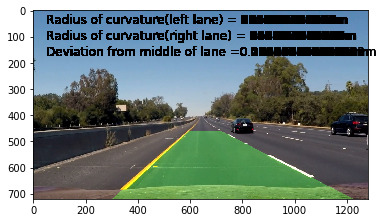

In [12]:
video_output = 'result.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(lane_video) 
white_clip.write_videofile(video_output, audio=False)